In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets

import difi
import thor

import variant_orbits
import scheduling
import detection_probability
import magnitudes

In [4]:
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.6 * fs,
          'ytick.labelsize': 0.6 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

%config InlineBackend.figure_format = 'retina'

# Assess Algorithm Accuracy

### Get data

In [4]:
detection_window = 15
min_nights = 3

In [8]:
def get_results(obj_type="neo", night_range=range(363)):
    real_det_nights = pd.read_hdf(f"findable_obs_{obj_type}.h5")
    probs = [None for _ in night_range]
    hexs = [None for _ in night_range]
    det_window = [None for _ in night_range]
    det_ever = [None for _ in night_range]
    for i, night in enumerate(night_range):
        night_probs, unique_objs = np.load(f"latest_runs/{obj_type}_night{night}_probs.npy", allow_pickle=True)

        reduced = real_det_nights.loc[list(set(real_det_nights.index).intersection(set(unique_objs)))]

        already_ids = reduced[reduced < night].index.values
        window_ids = reduced[(reduced >= night) &
                             (reduced < night + detection_window)].index.values
        ever_ids = reduced[(reduced >= night + detection_window)].index.values

        # hack for neos before I fixed it
        if obj_type == "neo":
            yet_to_be_found = ~np.isin(unique_objs, already_ids)
            unique_objs = unique_objs[yet_to_be_found]
            night_probs = night_probs[yet_to_be_found]

        probs[i] = night_probs
        hexs[i] = unique_objs
        det_window[i] = np.isin(unique_objs, window_ids)
        det_ever[i] = np.isin(unique_objs, ever_ids)
    probs = np.concatenate(probs)
    hexs = np.concatenate(hexs)
    det_window = np.concatenate(det_window)
    det_ever = np.concatenate(det_ever)
    
    return pd.DataFrame(data={"prob": probs, "hex_id": hexs, "det_window": det_window, "det_ever": det_ever},
                        columns=["prob", "hex_id", "det_window", "det_ever"])

In [9]:
neo_results = get_results(obj_type="neo")

In [10]:
%%time
mba_results = get_results(obj_type="mba")

KeyboardInterrupt: 

In [18]:
obs_dfs = [pd.read_hdf(f"../neocp/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
all_obs = pd.concat(obs_dfs)

In [19]:
n_unique = np.array([len(all_obs[all_obs["night"] == n]["ObjID"].unique()) for n in range(377)])

In [28]:
okay = n_unique != 0

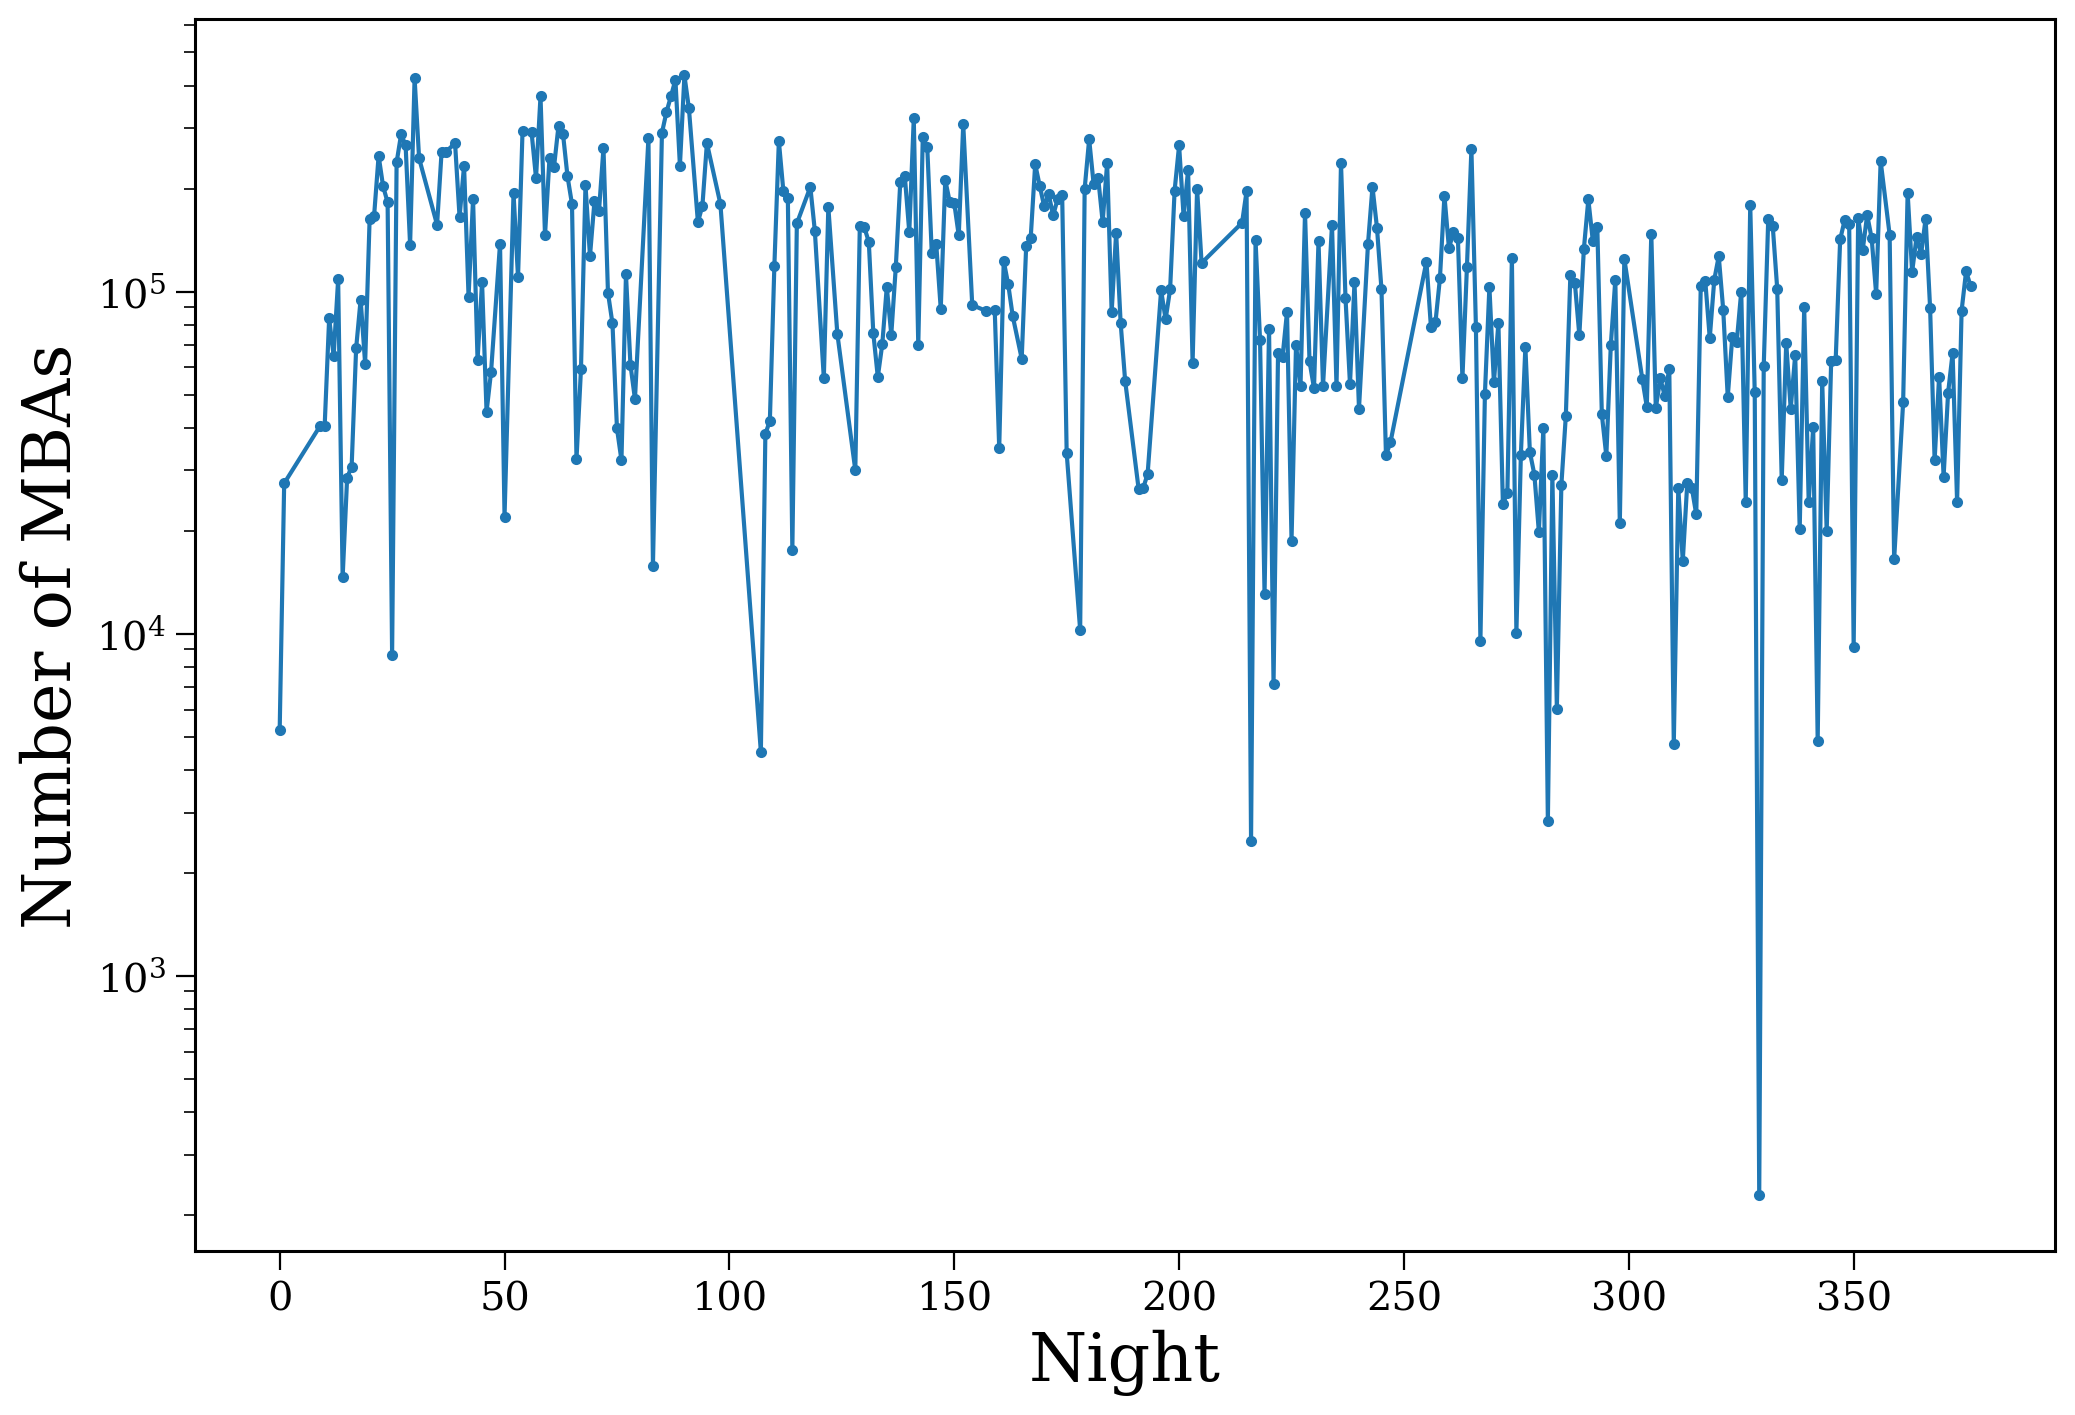

In [37]:
plt.plot(np.arange(377)[okay], n_unique[okay], marker="o", markersize=3)
plt.yscale("log")

plt.xlabel("Night")
plt.ylabel("Number of MBAs")

plt.show()

### Calculate stats and plot

In [22]:
def assess_algorithm_results(results,
                             threshold=0.5, obj_type="neo",
                             log=None, bin_count=50, dedup=False, plot=True, save_plot=False):
    if dedup:
        results = results.drop_duplicates(subset="hex_id", keep="first")
    if log is None:
        log = True if obj_type == "mba" else False
    correct_detectable = len(results["prob"][(results["prob"] >= threshold) & results["det_window"]])
    correct_undetectable = len(results["prob"][(results["prob"] < threshold) & ~results["det_window"]])
    incorrect_detectable = len(results["prob"][(results["prob"] >= threshold) & ~results["det_window"]])
    incorrect_undetectable = len(results["prob"][(results["prob"] < threshold) & results["det_window"]])

    c_u_eventually = len(results["prob"][(results["prob"] < threshold) & ~results["det_window"] & results["det_ever"]])
    i_d_eventually = len(results["prob"][(results["prob"] >= threshold) & ~results["det_window"] & results["det_ever"]])

    print(f'Of the {len(results["prob"])} objects, we classified')
    print(f"  {correct_detectable + correct_undetectable} correctly")
    print(f"    {correct_detectable} were detectable")
    print(f"    {correct_undetectable} were undetectable")
    print(f"  {incorrect_detectable + incorrect_undetectable} incorrectly")
    print(f"    {incorrect_detectable} were detectable")
    print(f"    {incorrect_undetectable} were undetectable")
    print(f'Overall success rate: {100 * (correct_detectable + correct_undetectable) / len(results["prob"]):1.2f}%')

    if not plot:
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [2, 1]})
    
    fig.suptitle(f"{obj_type.upper()}s", fontsize=1.1*fs)

    bins = np.linspace(0, 1, bin_count)
    
    axes[0].hist(results["prob"][results["det_window"]], label="Detected", bins=bins, log=log, edgecolor="none", rasterized=True)
    axes[0].hist(results["prob"][~results["det_window"]], alpha=0.6, label="Not detected", bins=bins, log=log, edgecolor="none", rasterized=True)
    axes[0].axvline(threshold, color="tab:red", linestyle="--", lw=3)

    axes[0].set_xlabel("Estimated probability of detection")
    axes[0].set_ylabel("Number of objects")
    axes[0].legend(fontsize=0.7*fs)

#     axes[1].set_title(f"{obj_type.upper()}s", fontsize=1.1*fs)

    axes[1].axvline(0.5, color="white", linestyle="dotted")
    axes[1].axhline(0.5, color="white", linestyle="dotted")

    axes[1].annotate("Detectable", xy=(0.25, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)
    axes[1].annotate("Undetectable", xy=(0.75, -0.02), xycoords="axes fraction", ha="center", va="top", fontsize=0.7*fs)

    axes[1].annotate("Undetectable", xy=(-0.02, 0.25), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)
    axes[1].annotate("Detectable", xy=(-0.02, 0.75), xycoords="axes fraction", ha="right", va="center", fontsize=0.7*fs, rotation=90)

    axes[1].annotate(incorrect_undetectable, xy=(0.25, 0.25), ha="center", va="center", fontsize=1.5*fs)
    axes[1].annotate("Excess NEOCP", xy=(0.25, 0.15), ha="center", va="center", fontsize=0.6*fs)
    axes[1].annotate(correct_undetectable, xy=(0.75, 0.25), ha="center", va="center", fontsize=1.5*fs)
    axes[1].annotate(f"{c_u_eventually} found after window", xy=(0.98, 0.02), ha="right", va="bottom", fontsize=0.4*fs)
    axes[1].annotate(incorrect_detectable, xy=(0.75, 0.75), ha="center", va="center", fontsize=1.5*fs)
    axes[1].annotate("Lost objects", xy=(0.75, 0.65), ha="center", va="center", fontsize=0.6*fs)
    axes[1].annotate(f"{i_d_eventually} found after window", xy=(0.98, 0.98), ha="right", va="top", fontsize=0.4*fs)
    axes[1].annotate(correct_detectable, xy=(0.25, 0.75), ha="center", va="center", fontsize=1.5*fs)

    axes[1].axvspan(0, 0.5, 0, 0.5, color=plt.cm.Reds(incorrect_undetectable / len(results["prob"])))
    axes[1].axvspan(0.5, 1, 0, 0.5, color=plt.cm.Greens(correct_undetectable / len(results["prob"])))
    axes[1].axvspan(0, 0.5, 0.5, 1, color=plt.cm.Greens(correct_detectable / len(results["prob"])))
    axes[1].axvspan(0.5, 1, 0.5, 1, color=plt.cm.Reds(incorrect_detectable / len(results["prob"])))

    axes[1].set_xlabel("\nTruth")
    axes[1].set_ylabel("Prediction\n")

    axes[1].set_xticks([])
    axes[1].set_yticks([])

    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)

    if save_plot:
        plt.savefig(f"../paper/figures/contingency_{obj_type}.pdf", format="pdf", bbox_inches="tight")

    plt.show()

In [41]:
def what_if_threshold(threshold, neo_results, mba_results, num_nights, dedup=False):
    
    if dedup:
        neo_results = neo_results.drop_duplicates(subset="hex_id", keep="first")
        mba_results = mba_results.drop_duplicates(subset="hex_id", keep="first")
    
    traffic = len(neo_results["prob"][neo_results["prob"] <= threshold])\
        + len(mba_results["prob"][mba_results["prob"] <= threshold])
    avg_traffic = traffic / num_nights
    purity = len(neo_results["prob"][neo_results["prob"] <= threshold]) / traffic 
    
    
    
    neos_lost = len(neo_results["prob"][(neo_results["prob"] > threshold)
                                        & ~neo_results["det_window"]
                                        & ~neo_results["det_ever"]])
    
    print(f"Using {num_nights} nights of data and assuming a threshold of {threshold} results in:")
    print(f"  - {avg_traffic:1.0f} objects submitted per night on average")
    print(f"  - {purity * 100:1.2f}% (~{purity * avg_traffic:1.0f}) of those will be NEOs")
    print(f"  - {neos_lost} NEOs will be lost (even after a year)")

In [42]:
interact(what_if_threshold,
         neo_results=fixed(neo_results), mba_results=fixed(mba_results),
         num_nights=fixed(363),
         threshold=widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.7),
         dedup=widgets.ToggleButton(
            value=False,
            description='De-duplicate',
            button_style='info',
            icon='check'),)

NameError: name 'neo_results' is not defined

Of the 10087 objects, we classified
  7419 correctly
    4896 were detectable
    2523 were undetectable
  2668 incorrectly
    1451 were detectable
    1217 were undetectable
Overall success rate: 73.55%


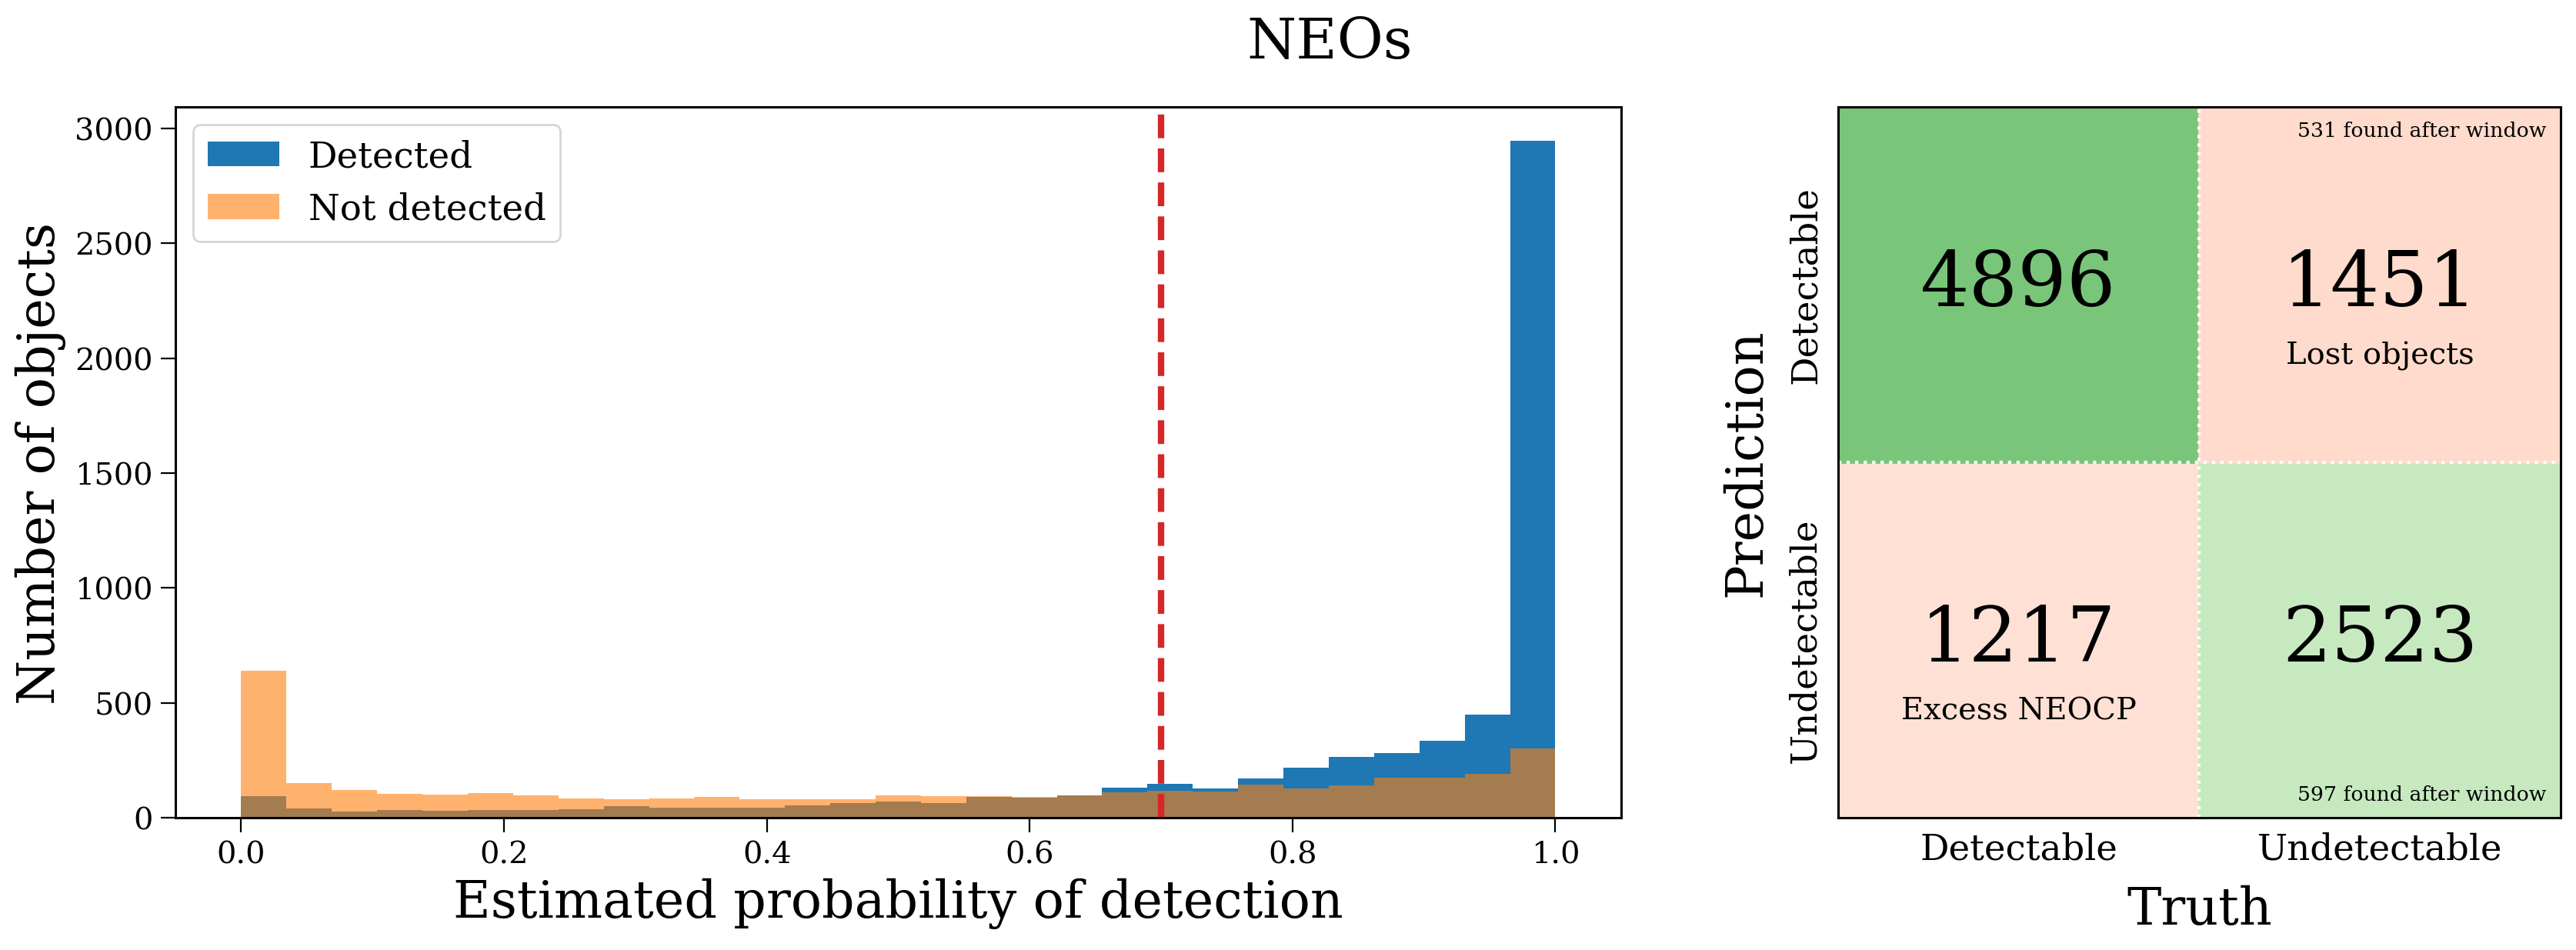

Of the 335646 objects, we classified
  256504 correctly
    208697 were detectable
    47807 were undetectable
  79142 incorrectly
    55087 were detectable
    24055 were undetectable
Overall success rate: 76.42%


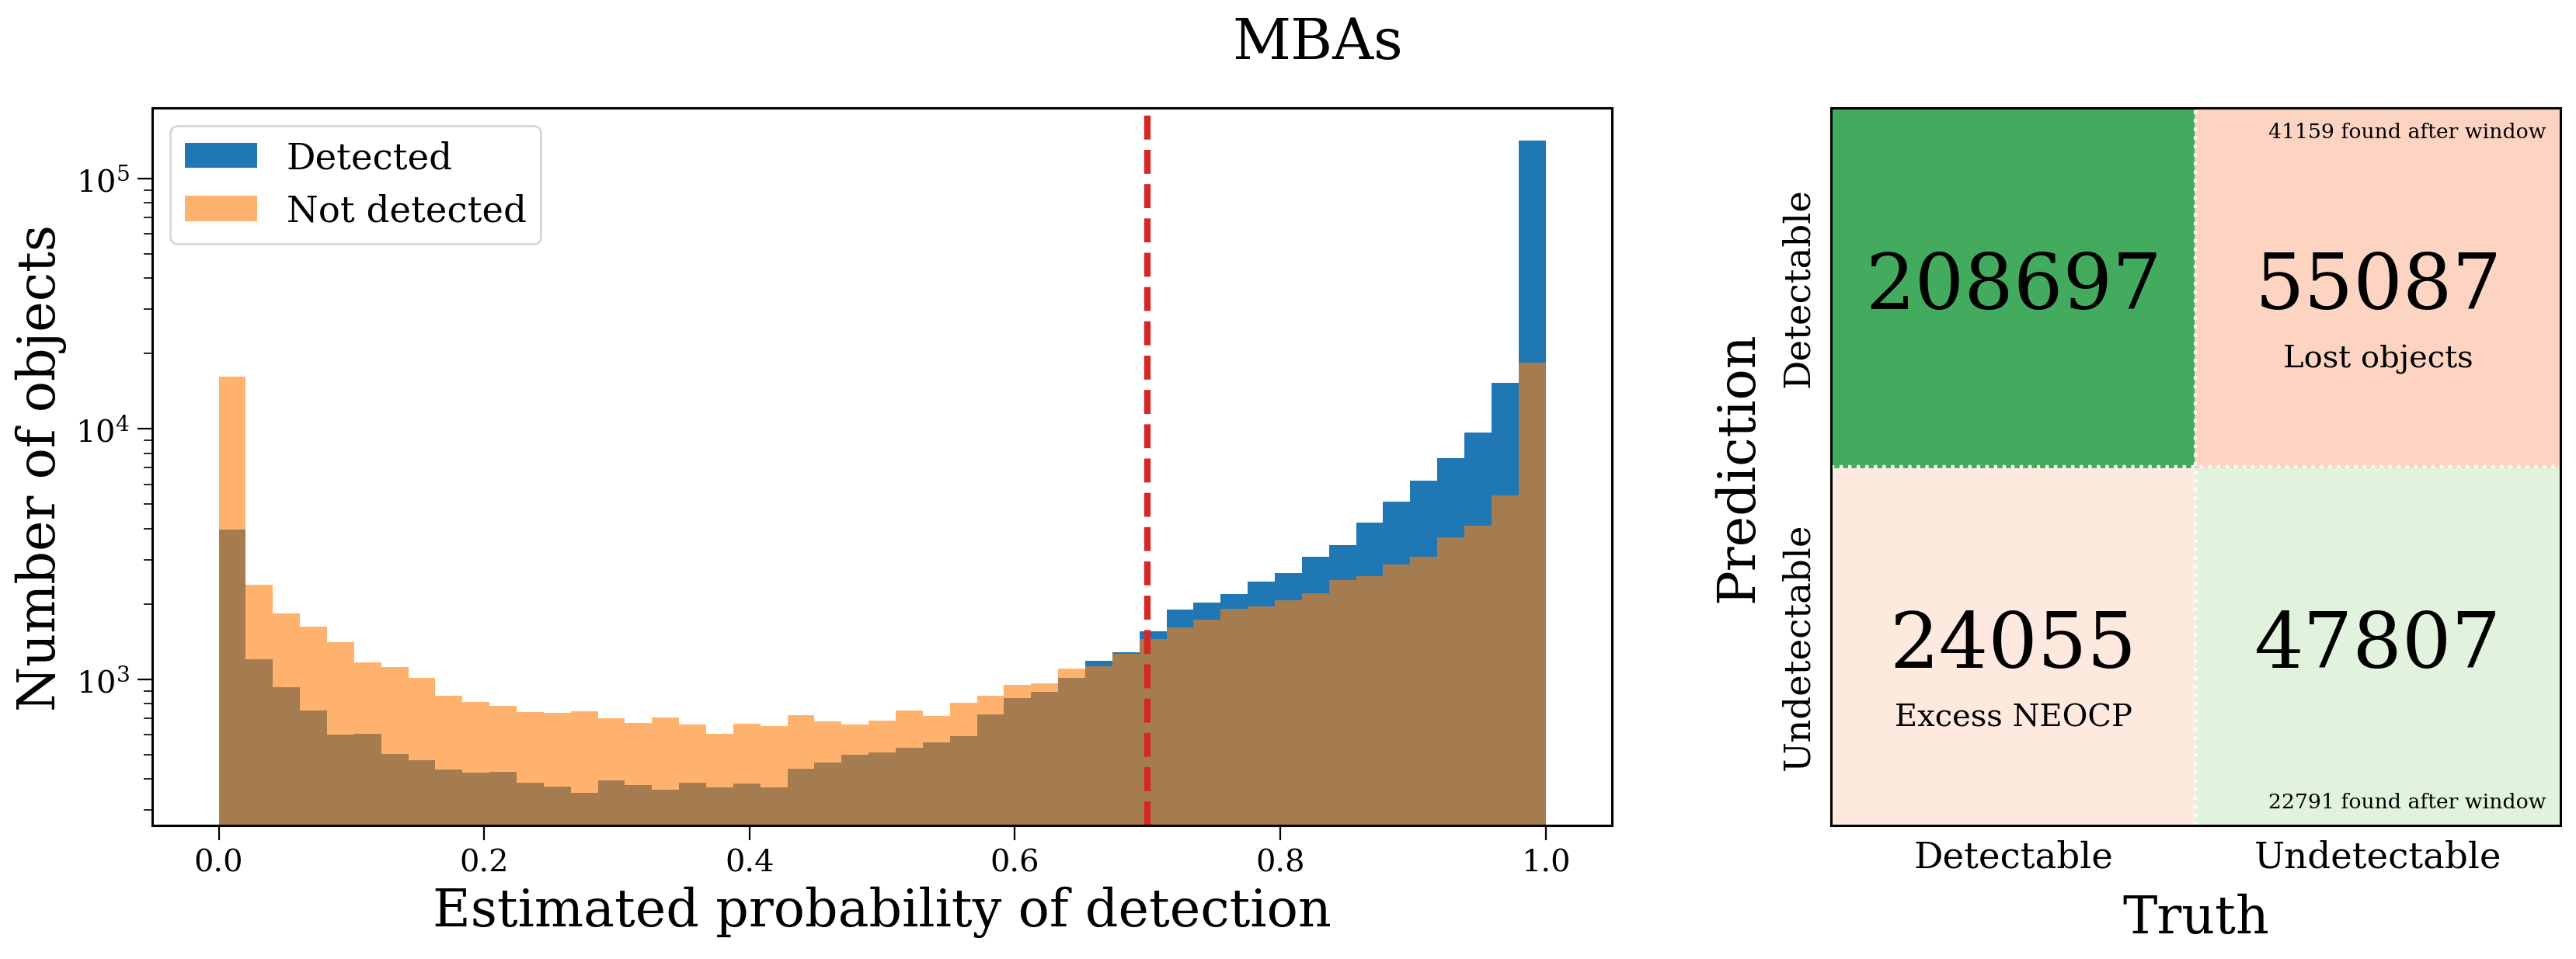

In [23]:
assess_algorithm_results(neo_results, threshold=0.7, obj_type="neo", bin_count=30, save_plot=True)
assess_algorithm_results(mba_results, threshold=0.7, obj_type="mba", save_plot=True)

In [325]:
!ls ../paper/figures

contingency_mba.pdf	 digest2_pollution.png
contingency_mba.png	 hybrid_vs_s3m_distributions.pdf
contingency_neo.pdf	 methods_placeholder.png
contingency_neo.png	 traffic_purity.pdf
density_comparisons.pdf  traffic_purity.png
density_residuals.pdf	 traffic_purity_unfindable.pdf
digest2_pollution.pdf	 traffic_purity_unfindable.png


Of the 6977 objects, we classified
  4957 correctly
    2824 were detectable
    2133 were undetectable
  2020 incorrectly
    1084 were detectable
    936 were undetectable
Overall success rate: 71.05%


<IPython.core.display.Javascript object>


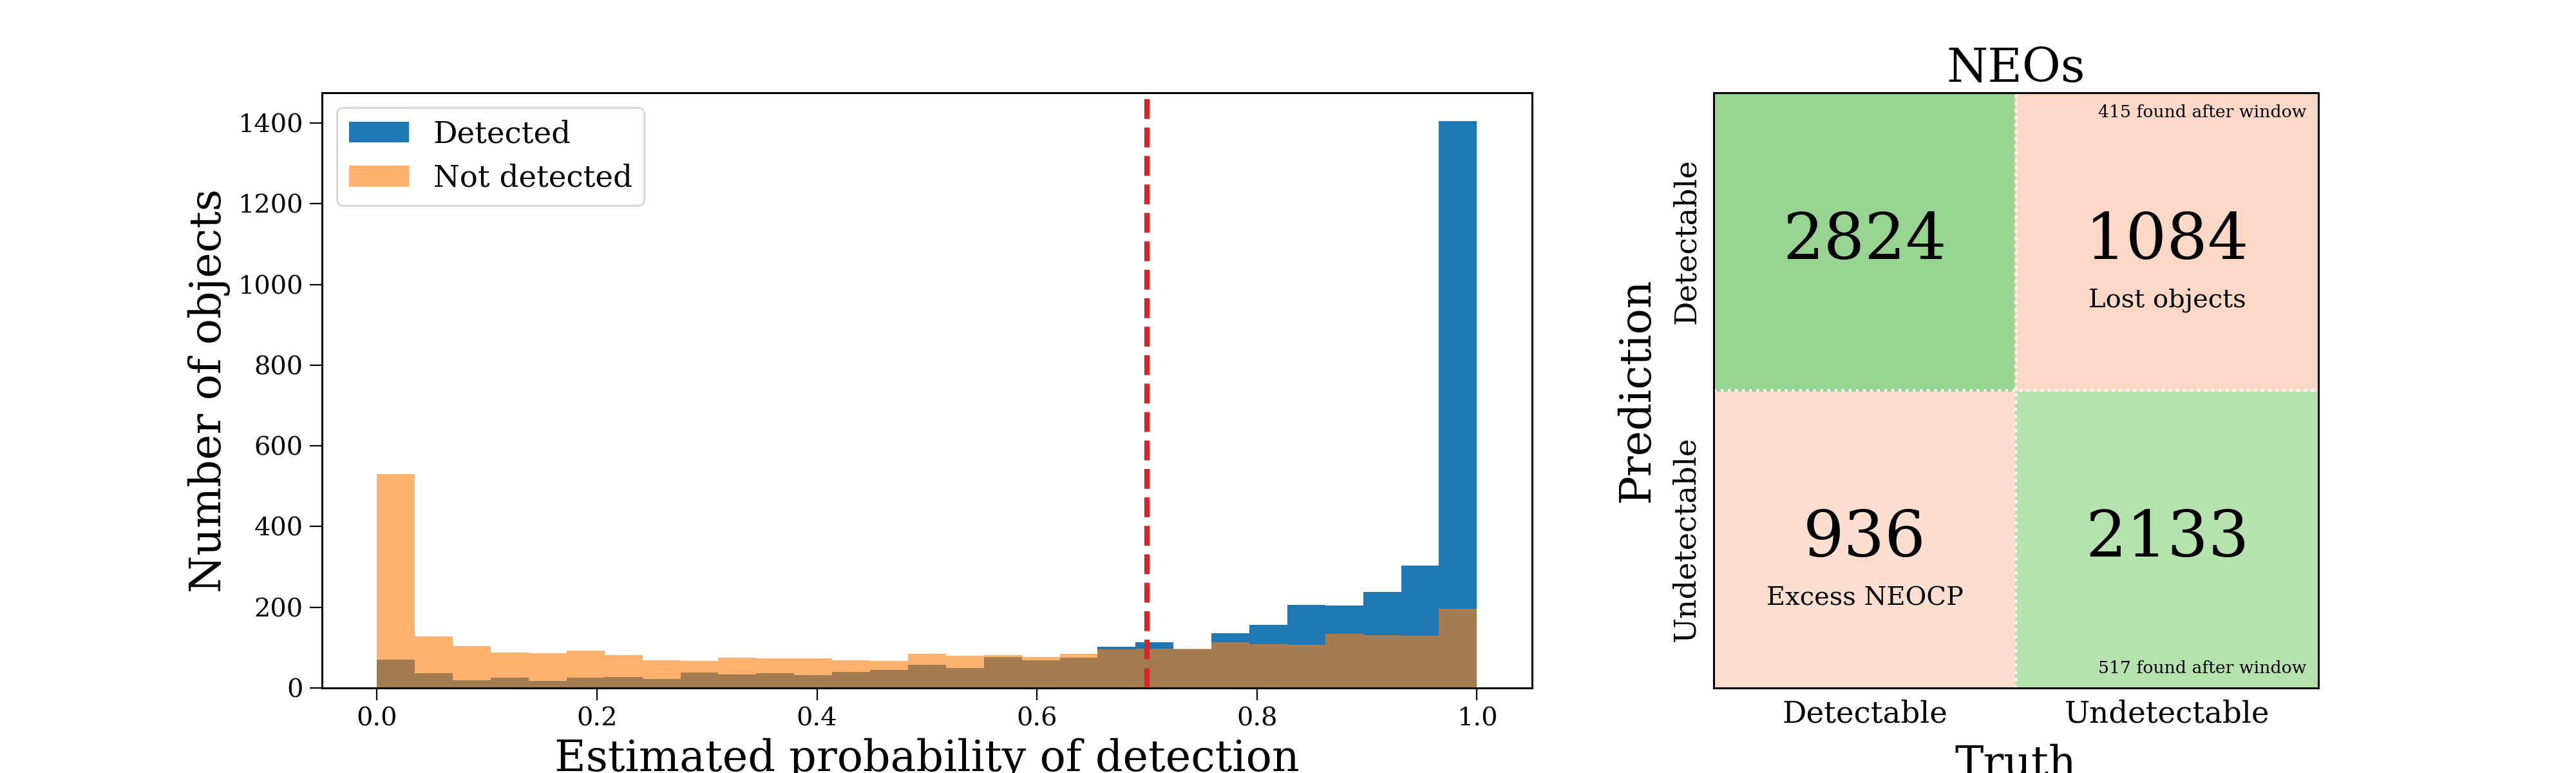

Of the 234375 objects, we classified
  171043 correctly
    129639 were detectable
    41404 were undetectable
  63332 incorrectly
    43999 were detectable
    19333 were undetectable
Overall success rate: 72.98%


<IPython.core.display.Javascript object>


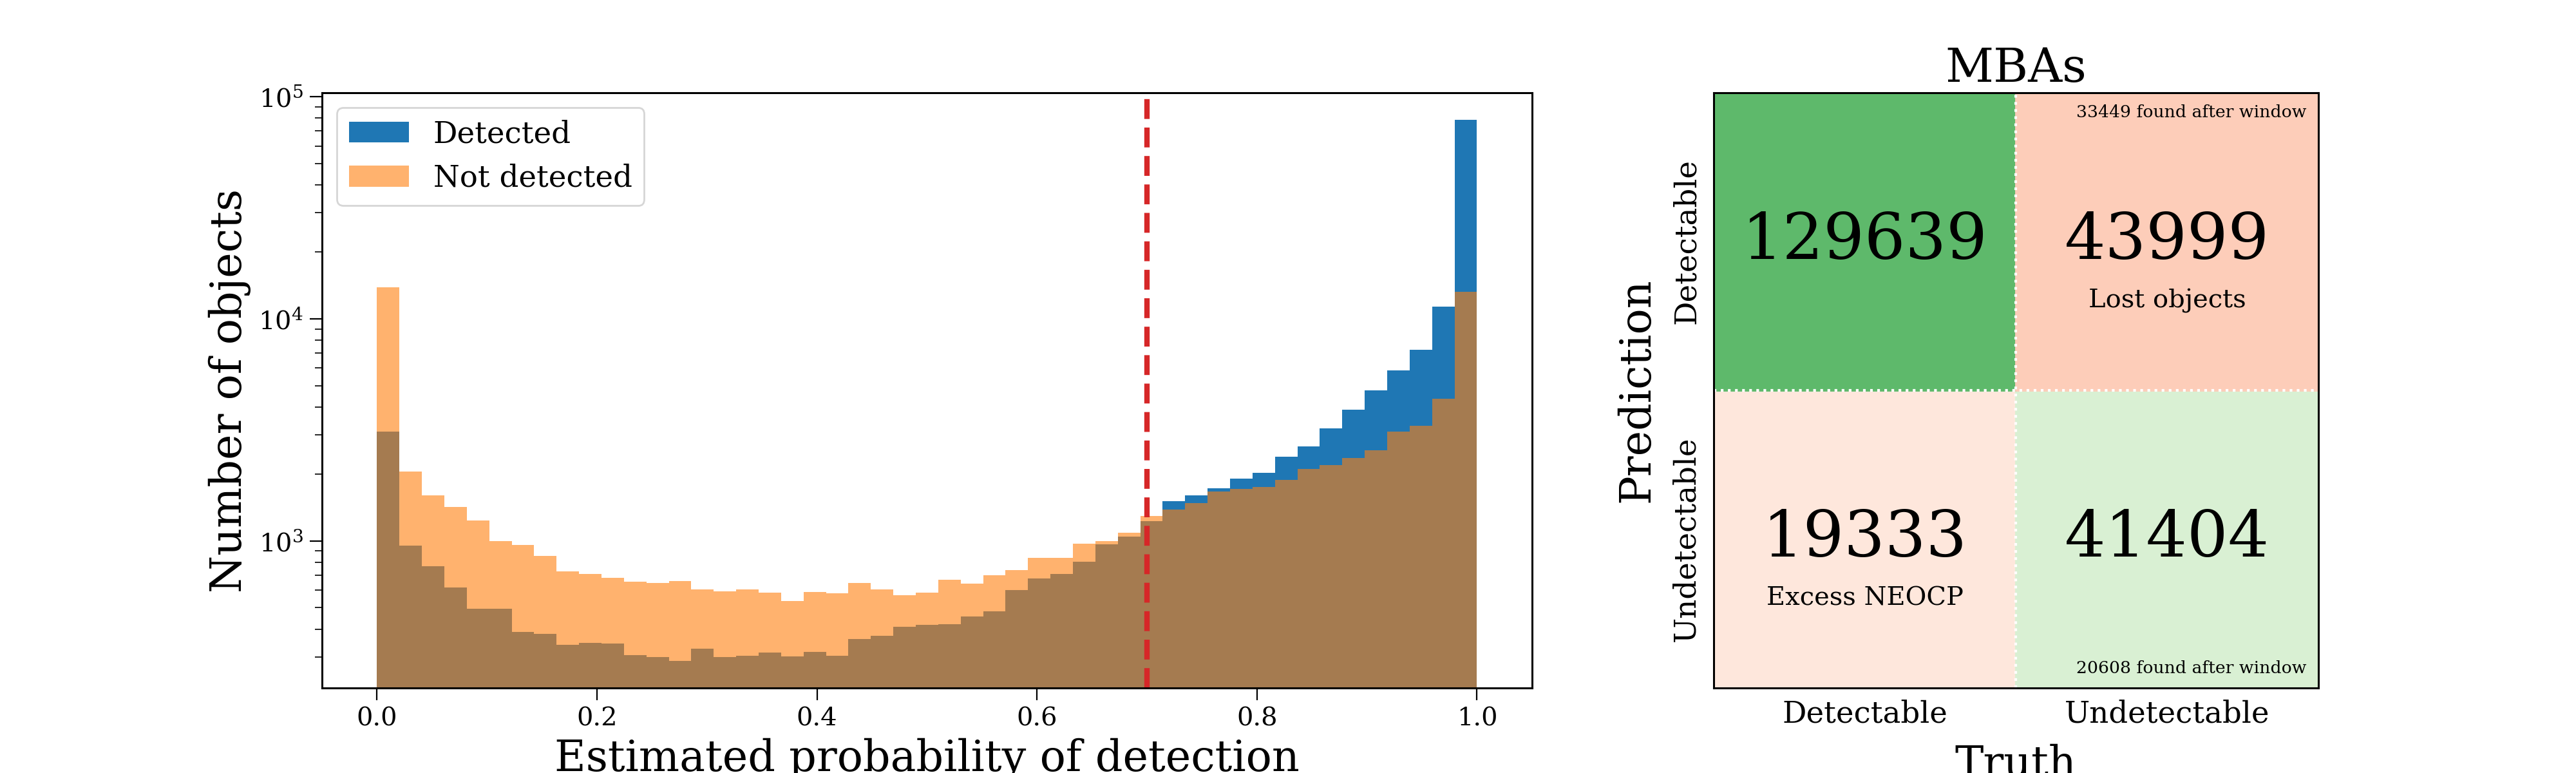

In [394]:
assess_algorithm_results(neo_results, threshold=0.7, obj_type="neo", bin_count=30, dedup=True)
assess_algorithm_results(mba_results, threshold=0.7, obj_type="mba", dedup=True)

## NEOs vs. MBAs

In [5]:
%%time
obs_dfs = [pd.read_hdf(f"../neocp/neo/filtered_visit_scores_{i:03d}.h5")
            for i in range(24)]
neo_obs = pd.concat(obs_dfs)
neo_obs = neo_obs[neo_obs["n_obs"] >= 3]

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
CPU times: user 1.6 s, sys: 283 ms, total: 1.89 s
Wall time: 4.28 s


In [6]:
%%time
obs_dfs = [pd.read_hdf(f"../neocp/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
mba_obs = pd.concat(obs_dfs)
# mba_obs = mba_obs[(mba_obs["scores"] >= 65) & (mba_obs["n_obs"] >= 3)]
mba_obs = mba_obs[mba_obs["n_obs"] >= 3]

CPU times: user 5min 45s, sys: 3min 11s, total: 8min 56s
Wall time: 9min 10s


In [7]:
neo_obs_dd = neo_obs.drop_duplicates(subset="ObjID")
mba_obs_dd = mba_obs.drop_duplicates(subset="ObjID")

## Plot setup

In [8]:
from matplotlib.patches import Patch

In [9]:
def compare_hists(var, label, ylabel, neo_obs, mba_obs,
                  bins="fd", density="both", figsize=(8, 16),
                  colours = {
                      "neo": list(plt.get_cmap("tab10")(1)),
                      "mba": list(plt.get_cmap("tab10")(4))
                  },
                  save_plot=None):
    neo_hist, var_bins = np.histogram(neo_obs[var], bins=bins, density=False)
    mba_hist, var_bins = np.histogram(mba_obs[var], bins=var_bins, density=False)

    handles = [Patch(facecolor=colours["neo"][:-1] + [0.2],
                         edgecolor=colours["neo"],
                         label="NEOs", lw=3),
               Patch(facecolor=colours["mba"][:-1] + [0.2],
                         edgecolor=colours["mba"],
                         label="MBAs", lw=3)]
    
    def _hists(ax, dens):
        ax.hist(neo_obs[var], bins=var_bins, density=dens, label="NEOs", facecolor=colours["neo"][:-1] + [0.2], lw=3)
        ax.hist(neo_obs[var], bins=var_bins, density=dens, color=colours["neo"], histtype="step", lw=3)

        ax.hist(mba_obs[var], bins=var_bins, density=dens, label="MBAs", facecolor=colours["mba"][:-1] + [0.2], lw=3)
        ax.hist(mba_obs[var], bins=var_bins, density=dens, color=colours["mba"], histtype="step", lw=3)
        ax.legend(handles=handles, loc="upper center", ncol=2, fontsize=0.8 * fs)

        if dens:
            ax.set_ylabel(r"$\mathrm{d}N/\mathrm{d}$" + ylabel)
        else:
            ax.set_yscale("log")
            ax.set_ylabel("Number of objects")
    
    if density == "both":
        fig, axes = plt.subplots(3, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 2, 1]}, sharex=True)
        for ax, dens in zip(axes[:-1], [True, False]):
            _hists(ax, dens)
    else:
        fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={"height_ratios": [2, 1]}, sharex=True)
        _hists(axes[0], density)
    
    centres = (var_bins[1:] + var_bins[:-1]) / 2
    axes[-1].plot(centres[mba_hist > 0], neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0], marker="o")
    centres = (var_bins[1:] + var_bins[:-1]) / 2
    axes[-1].scatter(centres[mba_hist <= 0],
                     np.repeat(max(neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0]), (mba_hist <= 0).sum()),
                     marker=r"$\infty$", color="tab:blue", zorder=10)
    axes[-1].set_yscale("log")
    axes[-1].set_xlabel(label)
    axes[-1].set_ylabel(r"$N_{\rm NEO}/N_{\rm MBA}$")
    axes[-1].grid()
    
    if np.any(neo_hist[mba_hist > 0] / mba_hist[mba_hist > 0] >= 1.0):
        axes[-1].axhline(1.0, linestyle="dotted", color="grey")
        
    for ax in axes[:-1]:
        ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
    axes[0].annotate("a", xy=(0.02, 0.98), xycoords="axes fraction", fontsize=0.5*fs, va="top",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))
    axes[1].annotate("b", xy=(0.98, 0.98), xycoords="axes fraction", fontsize=0.5*fs, va="top", ha="right",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))
    axes[2].annotate("c", xy=(0.02, 0.96), xycoords="axes fraction", fontsize=0.5*fs, va="top",
                     bbox=dict(boxstyle="circle", facecolor="lightgrey", edgecolor="none"))    
        
    if save_plot is not None:
        plt.savefig(save_plot, format="pdf", bbox_inches="tight")

    plt.show()

In [10]:
f'{len(neo_obs_dd[neo_obs_dd["scores"] >= 65]) / (len(neo_obs_dd[neo_obs_dd["scores"] >= 65]) + len(mba_obs_dd[mba_obs_dd["scores"] >= 65])) * 100:1.1f}%'

'3.0%'

In [27]:
even_top_score = (len(neo_obs_dd[neo_obs_dd["scores"] == 100])
    / (len(neo_obs_dd[neo_obs_dd["scores"] == 100]) + len(mba_obs_dd[mba_obs_dd["scores"] == 100])) * 100)
f'{even_top_score:1.1f}%'

'20.3%'

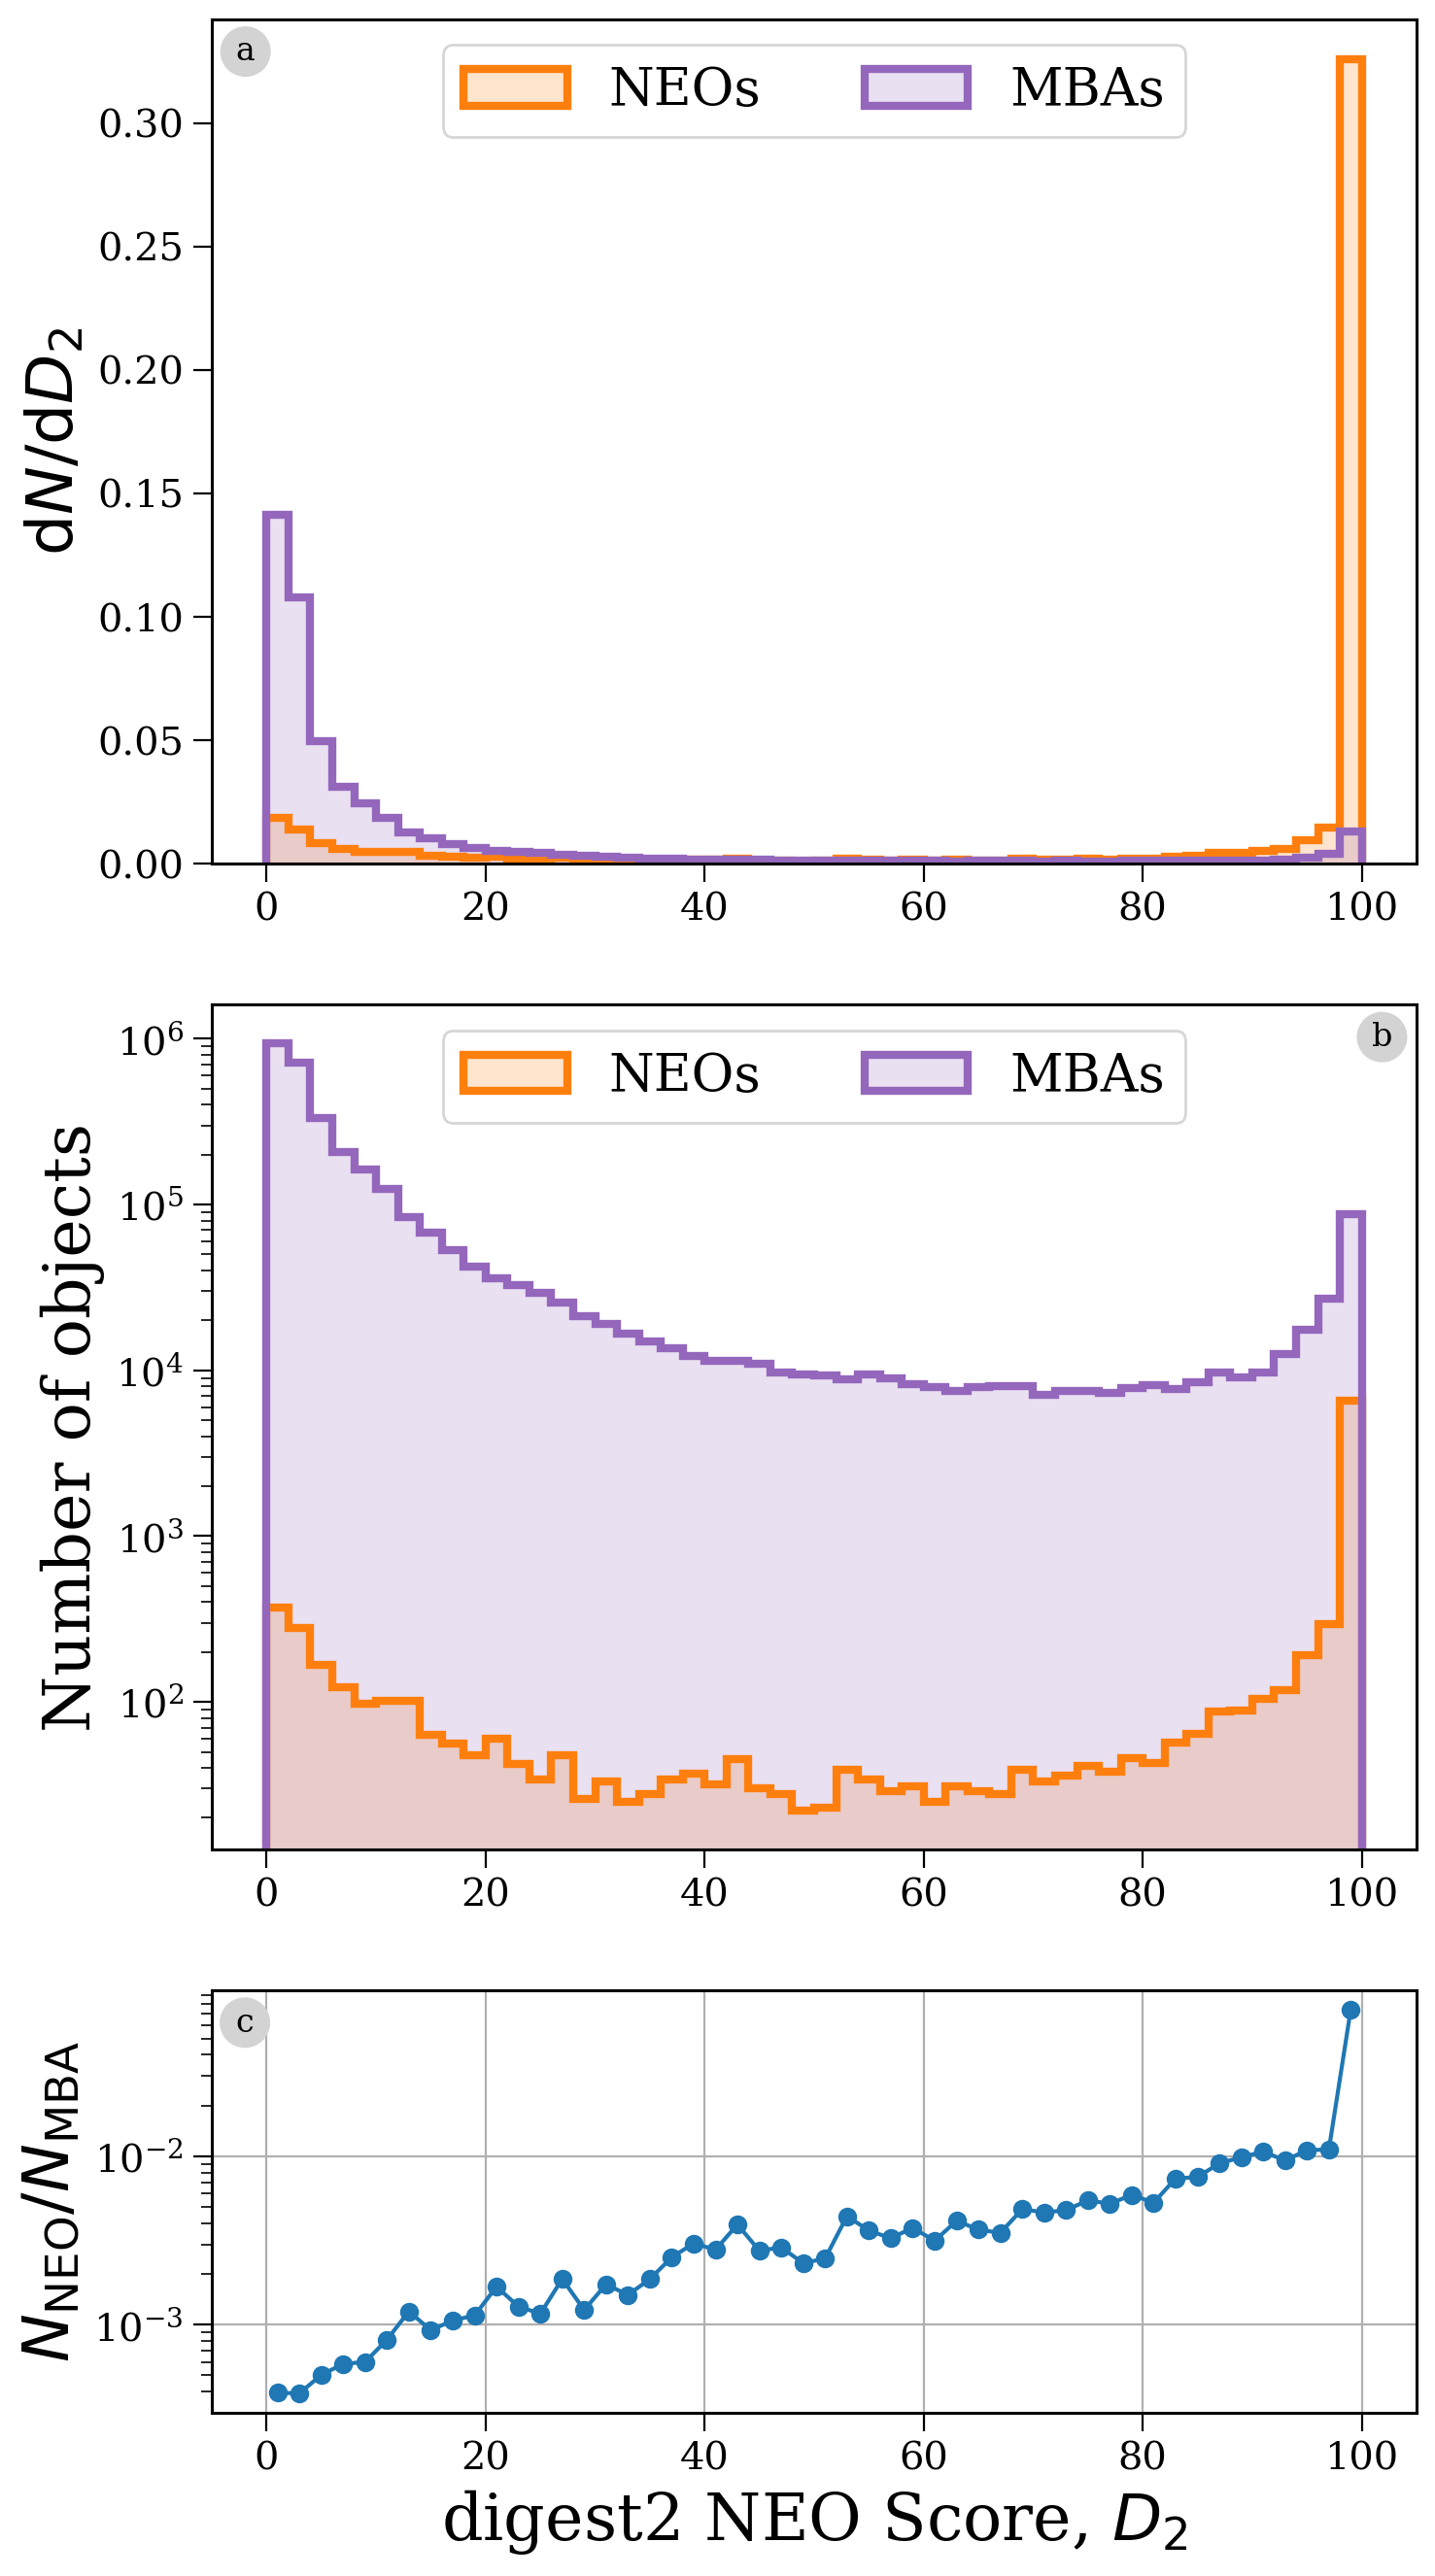

CPU times: user 1.91 s, sys: 26.5 ms, total: 1.94 s
Wall time: 2.46 s


In [24]:
%%time
compare_hists("scores", r"digest2 NEO Score, $D_2$", r"$D_2$", neo_obs_dd, mba_obs_dd, density="both", bins=np.linspace(0, 100, 51), figsize=(8, 16), save_plot="../paper/figures/digest2_pollution.pdf")

### Magnitude things

In [11]:
%%time
obs_dfs = [pd.read_hdf(f"../neocp/neo/filtered_visit_scores_{i:03d}.h5")
            for i in range(24)]
neo_obs = pd.concat(obs_dfs)
neo_obs = neo_obs[(neo_obs["scores"] >= 65) & (neo_obs["n_obs"] >= 3)]

CPU times: user 8.77 s, sys: 4.5 s, total: 13.3 s
Wall time: 15.6 s


In [12]:
%%time
obs_dfs = [pd.read_hdf(f"../neocp/mba/filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
            for i in range(24)]
mba_obs = pd.concat(obs_dfs)
mba_obs = mba_obs[(mba_obs["scores"] >= 65) & (mba_obs["n_obs"] >= 3)]

CPU times: user 5min 4s, sys: 2min 1s, total: 7min 6s
Wall time: 7min 19s


In [13]:
neo_obs_dd = neo_obs.drop_duplicates(subset="ObjID")
mba_obs_dd = mba_obs.drop_duplicates(subset="ObjID")

In [31]:
v_mag = np.ones(len(neo_obs)) * np.inf
for filter_letter in "ugrizy":
    filter_mask = neo_obs["filter"] == filter_letter
    if filter_mask.any():
        v_mag[filter_mask] = magnitudes.convert_colour_mags(neo_obs[filter_mask]["MaginFilter"],
                                                            out_colour=filter_letter,
                                                            in_colour="V", convention="LSST",
                                                            asteroid_type="C")
neo_obs["v_mag"] = v_mag

In [16]:
v_mag = np.ones(len(mba_obs)) * np.inf
for filter_letter in "ugrizy":
    print(filter_letter)
    filter_mask = mba_obs["filter"] == filter_letter
    if filter_mask.any():
        v_mag[filter_mask] = magnitudes.convert_colour_mags(mba_obs[filter_mask]["MaginFilter"],
                                                         out_colour=filter_letter,
                                                         in_colour="V", convention="LSST",
                                                         asteroid_type="C")
mba_obs["v_mag"] = v_mag

u
g
r
i
z
y


In [17]:
obs_hexs = np.concatenate((neo_obs.index.unique().values, mba_obs.index.unique().values))

In [20]:
%%time
s3m_matches = s3m_cart[s3m_cart["hex_id"].isin(obs_hexs)]

CPU times: user 8.97 s, sys: 921 ms, total: 9.89 s
Wall time: 9.8 s


In [21]:
neo_obs = neo_obs.join(other=s3m_matches["H"], on="ObjID")
mba_obs = mba_obs.join(other=s3m_matches["H"], on="ObjID")

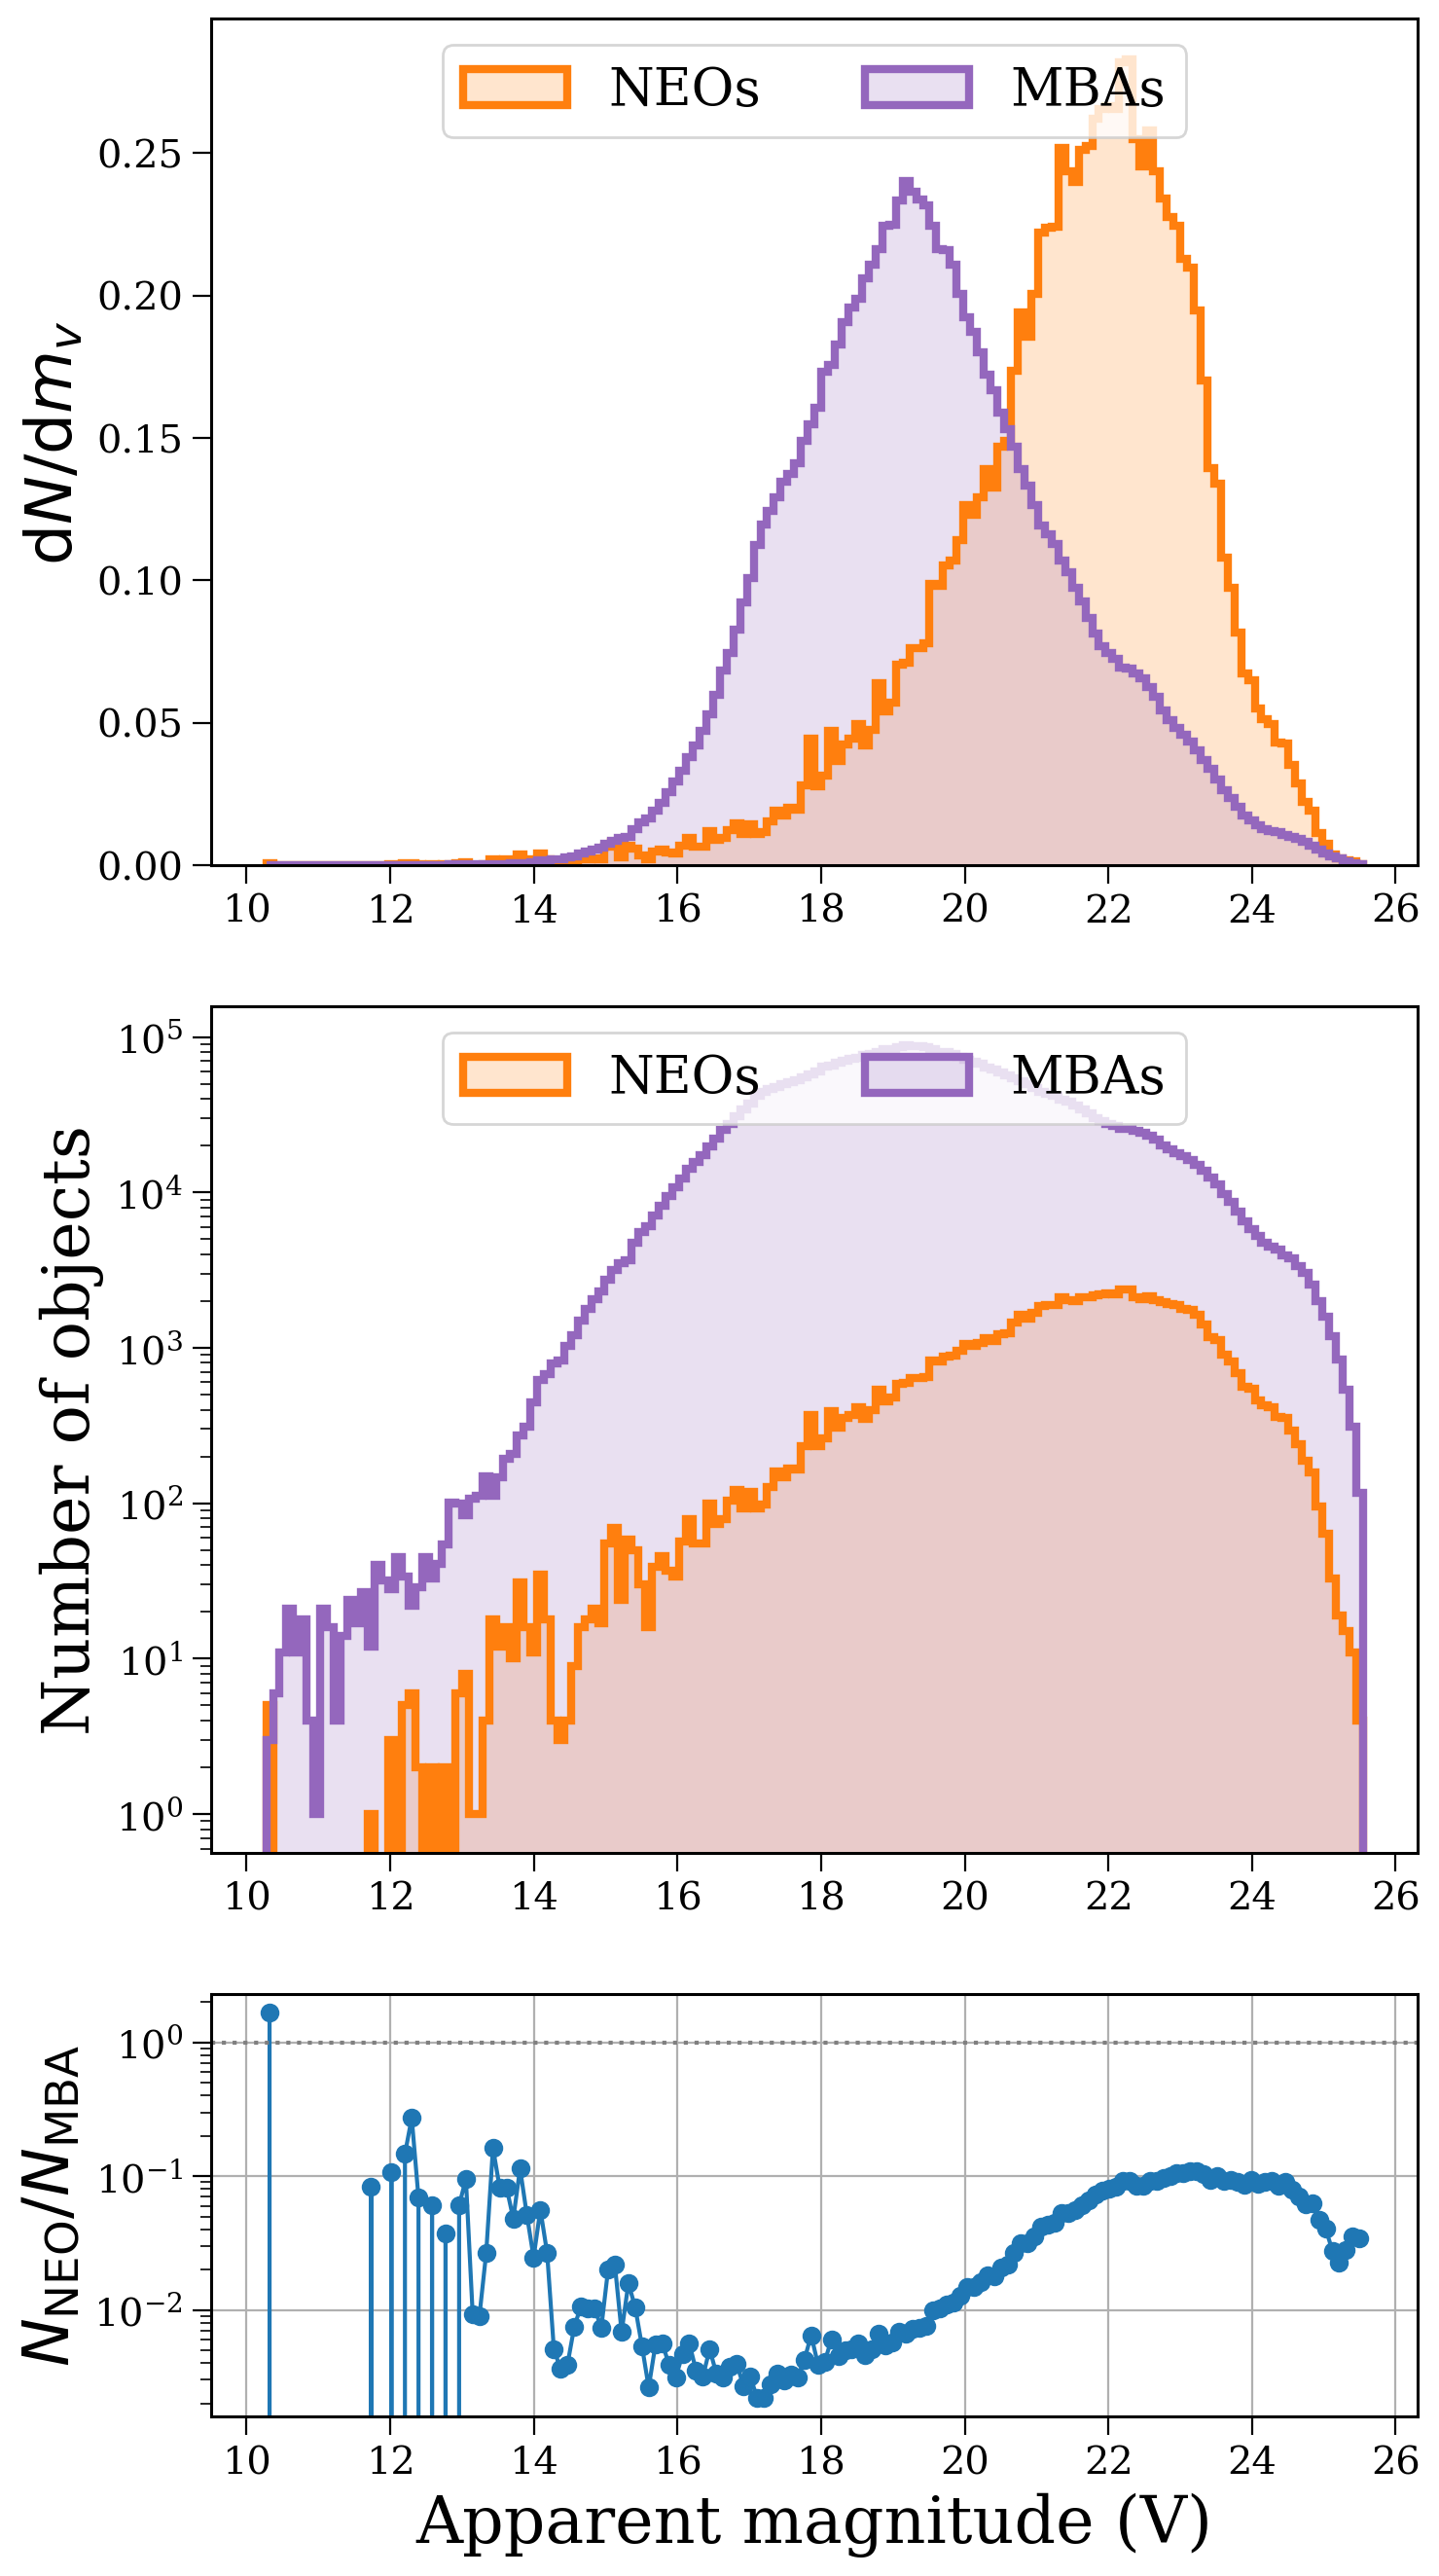

CPU times: user 4.82 s, sys: 119 ms, total: 4.94 s
Wall time: 4.94 s


In [366]:
%%time
compare_hists("v_mag", "Apparent magnitude (V)", r"$m_v$", neo_obs, mba_obs, density="both", figsize=(8, 16))

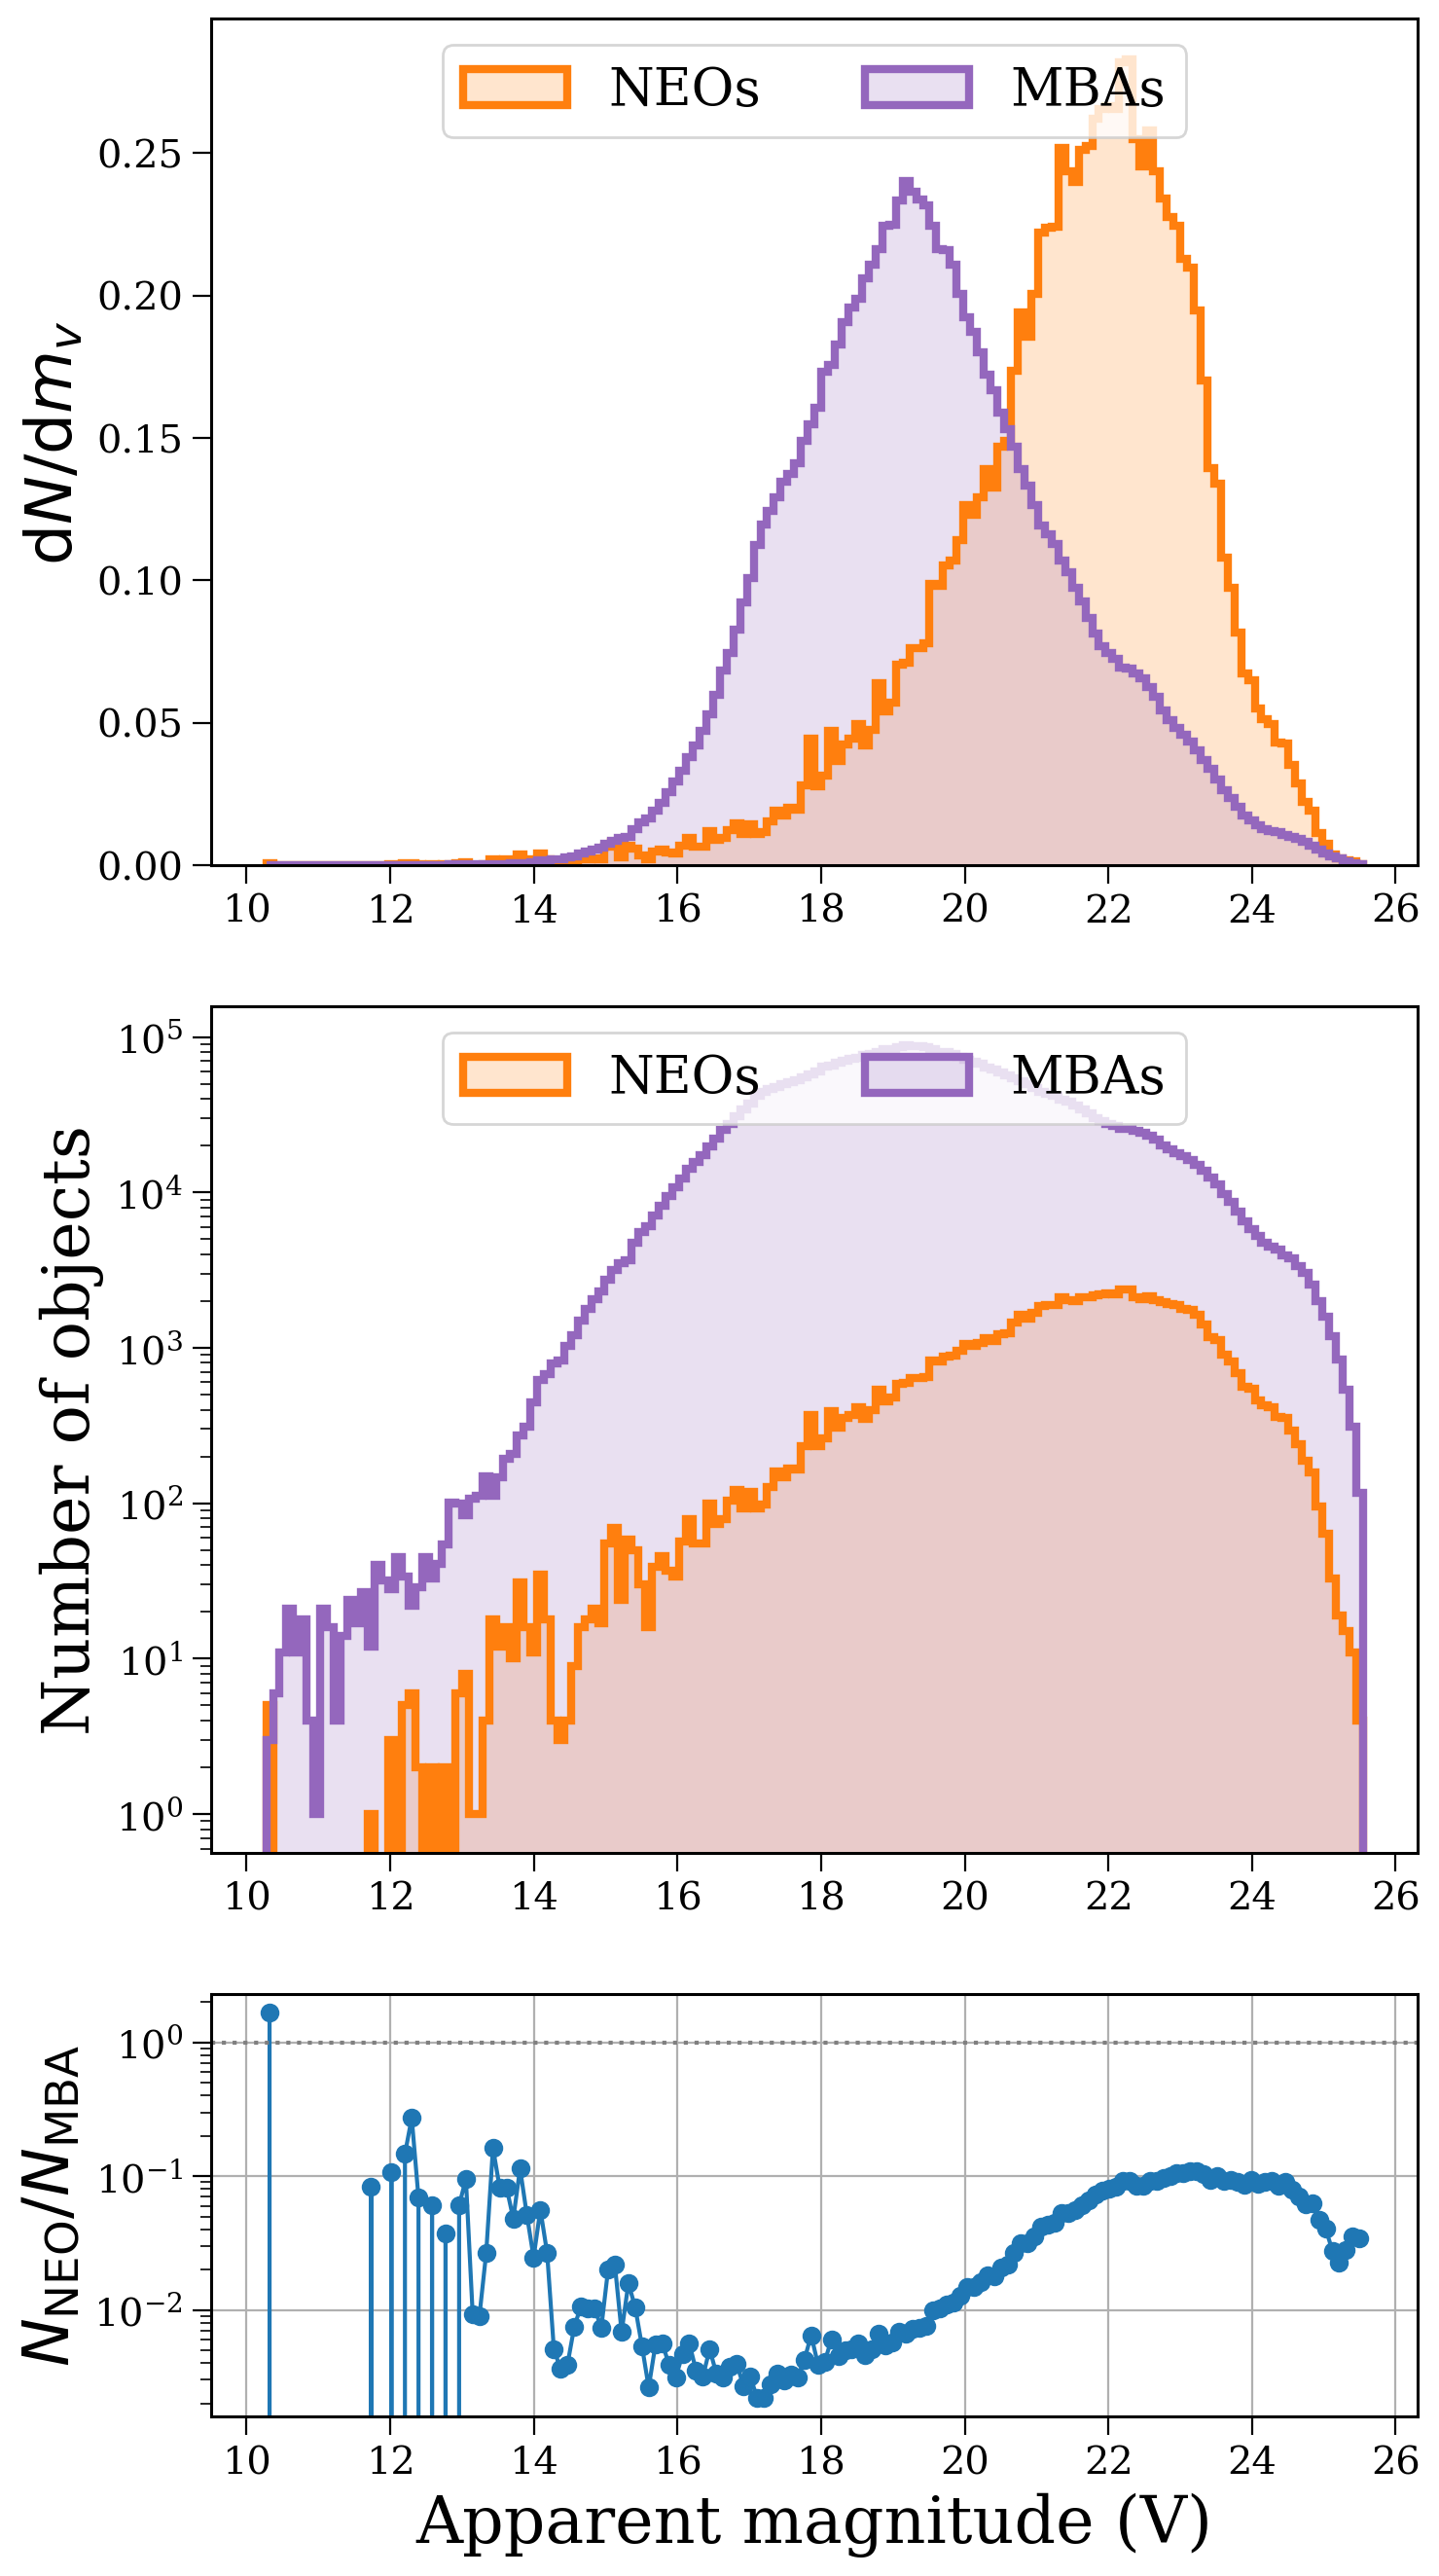

CPU times: user 4.82 s, sys: 119 ms, total: 4.94 s
Wall time: 4.94 s


In [366]:
%%time
compare_hists("H", "Absolute magnitude, $H$", r"$H$", neo_obs, mba_obs, density="both", figsize=(8, 16))

# Ecliptic Latitude cut for year 1

In [14]:
epsilon = 23.4392811*np.pi/180 #obliquity
def ecliptic_latitude(alpha, delta):
    return np.rad2deg(np.arcsin(np.cos(epsilon) * np.sin(delta) - np.sin(epsilon) * np.cos(delta) * np.sin(alpha)))

In [15]:
neo_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(neo_obs_dd["AstRA(deg)"]),
                                          np.deg2rad(neo_obs_dd["AstDec(deg)"]))
mba_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(mba_obs_dd["AstRA(deg)"]),
                                          np.deg2rad(mba_obs_dd["AstDec(deg)"]))

/tmp/ipykernel_98261/2377206901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neo_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(neo_obs_dd["AstRA(deg)"]),
/tmp/ipykernel_98261/2377206901.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mba_obs_dd["ecl_lat"] = ecliptic_latitude(np.deg2rad(mba_obs_dd["AstRA(deg)"]),


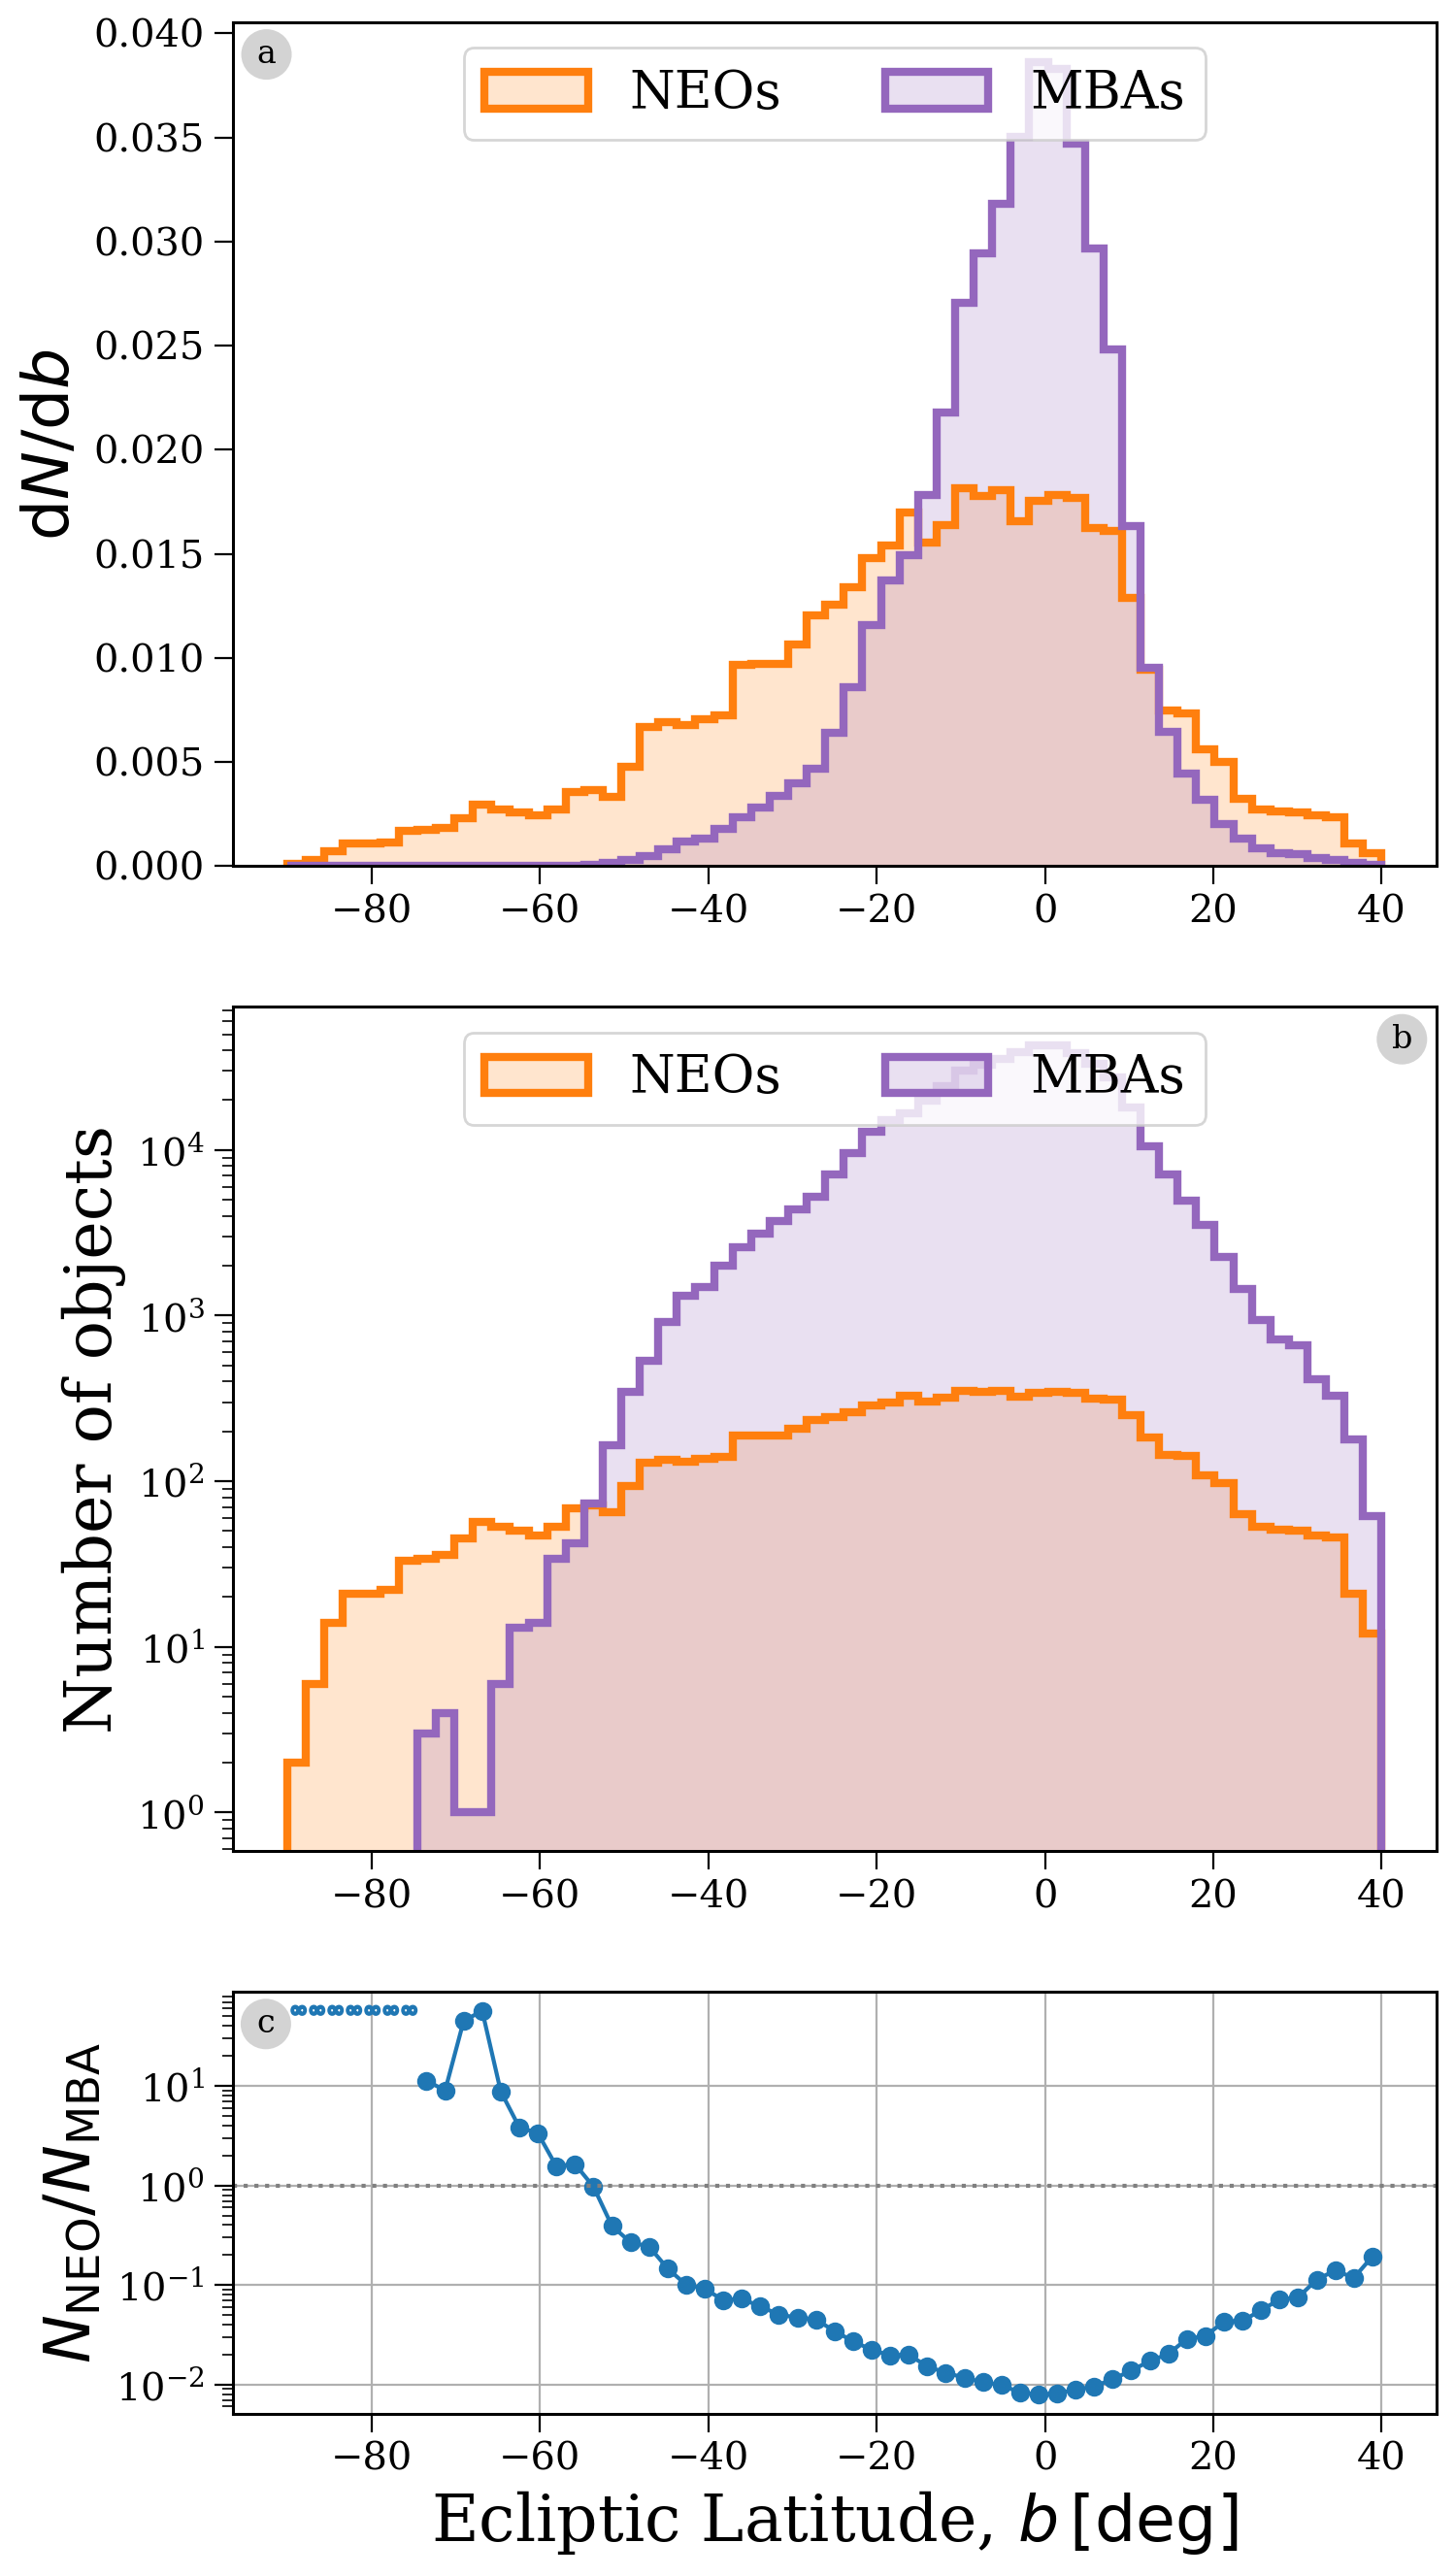

In [86]:
compare_hists("ecl_lat", r"Ecliptic Latitude, $b \, [\rm deg]$", r"$b$", neo_obs_dd, mba_obs_dd,
              bins=np.linspace(-90, 40, 60))

In [16]:
def first_year_stats_unique(neo_obs, mba_obs, cutoff):
    n_neo = len(neo_obs[neo_obs["ecl_lat"] <= cutoff].index.unique())
    n_mba = len(mba_obs[mba_obs["ecl_lat"] <= cutoff].index.unique())
    return n_neo + n_mba, n_neo / (n_neo + n_mba)

def first_year_stats(neo_obs, mba_obs, cutoff):
    n_neo = (abs(neo_obs["ecl_lat"]) >= cutoff).sum()
    n_mba = (abs(mba_obs["ecl_lat"]) >= cutoff).sum()
    avg_mag = np.median(np.concatenate((neo_obs["MaginFilter"][abs(neo_obs["ecl_lat"]) >= cutoff],
                                        mba_obs["MaginFilter"][abs(mba_obs["ecl_lat"]) >= cutoff])))
    return n_neo + n_mba, n_neo / (n_neo + n_mba), avg_mag

In [17]:
%%time
cutoffs = np.linspace(0, abs(min(neo_obs_dd["ecl_lat"])), 1000)
first_year_traffic = np.zeros_like(cutoffs)
first_year_purity = np.zeros_like(cutoffs)

for i in range(len(cutoffs)):
    first_year_traffic[i], first_year_purity[i], _ = first_year_stats(neo_obs_dd,
                                                                      mba_obs_dd,
                                                                      cutoffs[i])

CPU times: user 10 s, sys: 265 ms, total: 10.3 s
Wall time: 10.3 s


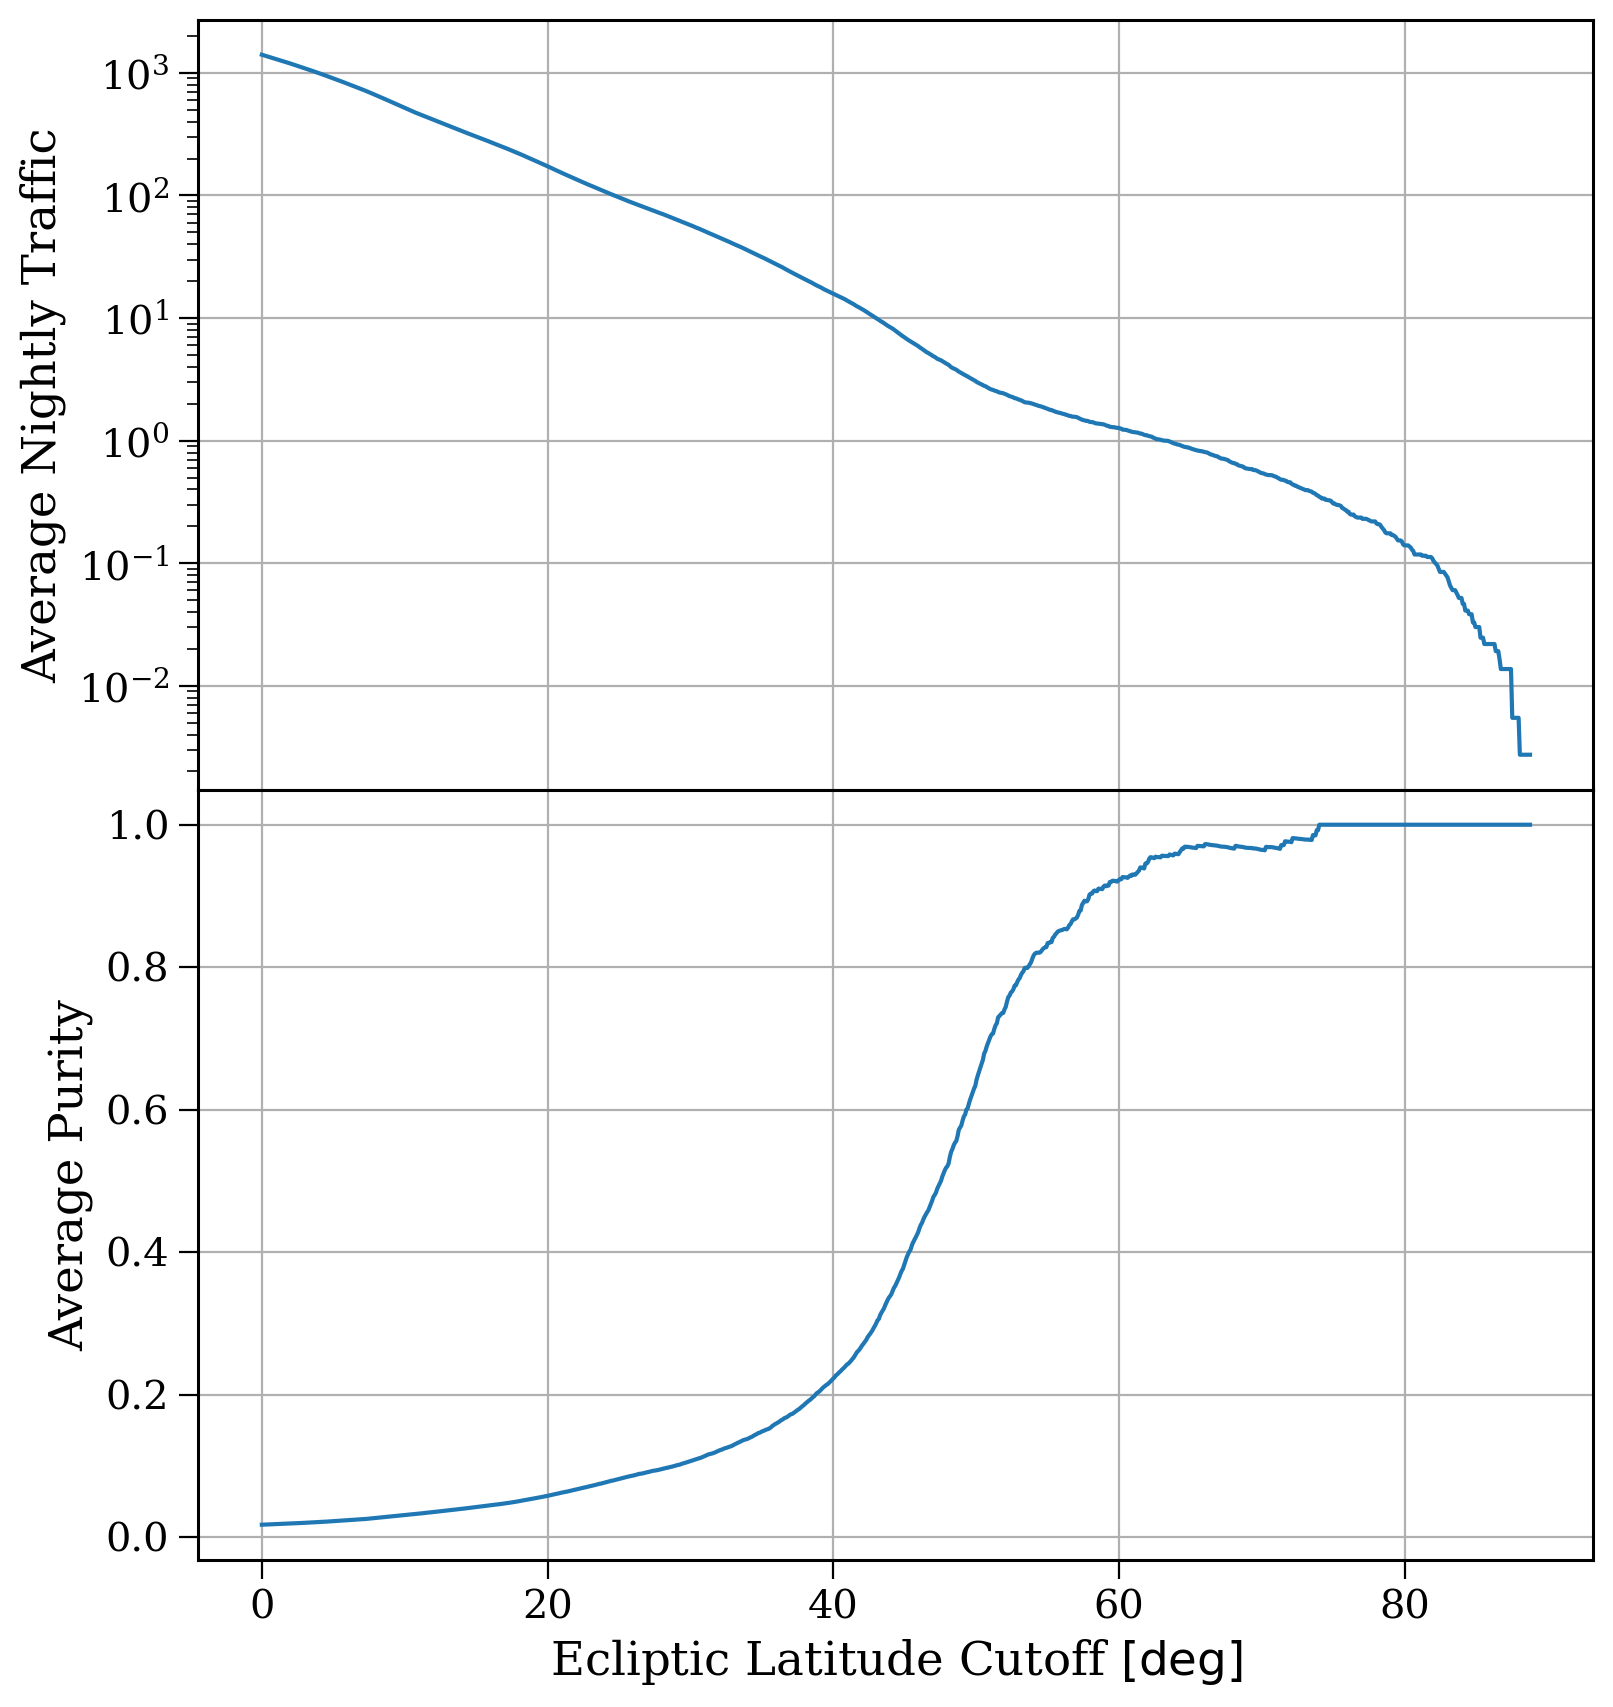

In [18]:
fig, axes = plt.subplots(2, 1, figsize=(9, 10), sharex=True)
fig.subplots_adjust(hspace=0)

axes[0].plot(cutoffs, first_year_traffic / 365)
axes[0].set_yscale("log")
axes[0].set_ylabel("Average Nightly Traffic", fontsize=0.7*fs)

axes[1].plot(cutoffs, first_year_purity)
axes[1].set_ylabel("Average Purity", fontsize=0.7*fs)
axes[1].set_xlabel(r"Ecliptic Latitude Cutoff $\rm [deg]$", fontsize=0.7*fs)

for ax in axes:
    ax.grid(True)

plt.show()

In [68]:
ecl_lat_data = ",".join(list(cutoffs.astype('str'))) + "\n"\
+ ",".join((first_year_traffic / 377).astype('str')) + "\n"\
+ ",".join((first_year_purity * 100).astype('str'))

In [69]:
with open("ecl_lat_data.csv", "w") as f:
    f.write(ecl_lat_data)

In [57]:
pd.DataFrame(data={"latitude_cutoff": cutoffs, "purity": first_year_purity, "traffic": first_year_traffic / 377}).to_json("ecliptic_latitude_neo.json", orient="split")

In [45]:
cutoffs

array([ 0.        ,  0.08887596,  0.17775192,  0.26662788,  0.35550384,
        0.4443798 ,  0.53325576,  0.62213172,  0.71100768,  0.79988364,
        0.8887596 ,  0.97763556,  1.06651152,  1.15538748,  1.24426344,
        1.3331394 ,  1.42201536,  1.51089132,  1.59976728,  1.68864324,
        1.7775192 ,  1.86639516,  1.95527112,  2.04414707,  2.13302303,
        2.22189899,  2.31077495,  2.39965091,  2.48852687,  2.57740283,
        2.66627879,  2.75515475,  2.84403071,  2.93290667,  3.02178263,
        3.11065859,  3.19953455,  3.28841051,  3.37728647,  3.46616243,
        3.55503839,  3.64391435,  3.73279031,  3.82166627,  3.91054223,
        3.99941819,  4.08829415,  4.17717011,  4.26604607,  4.35492203,
        4.44379799,  4.53267395,  4.62154991,  4.71042587,  4.79930183,
        4.88817779,  4.97705375,  5.06592971,  5.15480567,  5.24368163,
        5.33255759,  5.42143355,  5.51030951,  5.59918547,  5.68806143,
        5.77693739,  5.86581335,  5.9546893 ,  6.04356526,  6.13

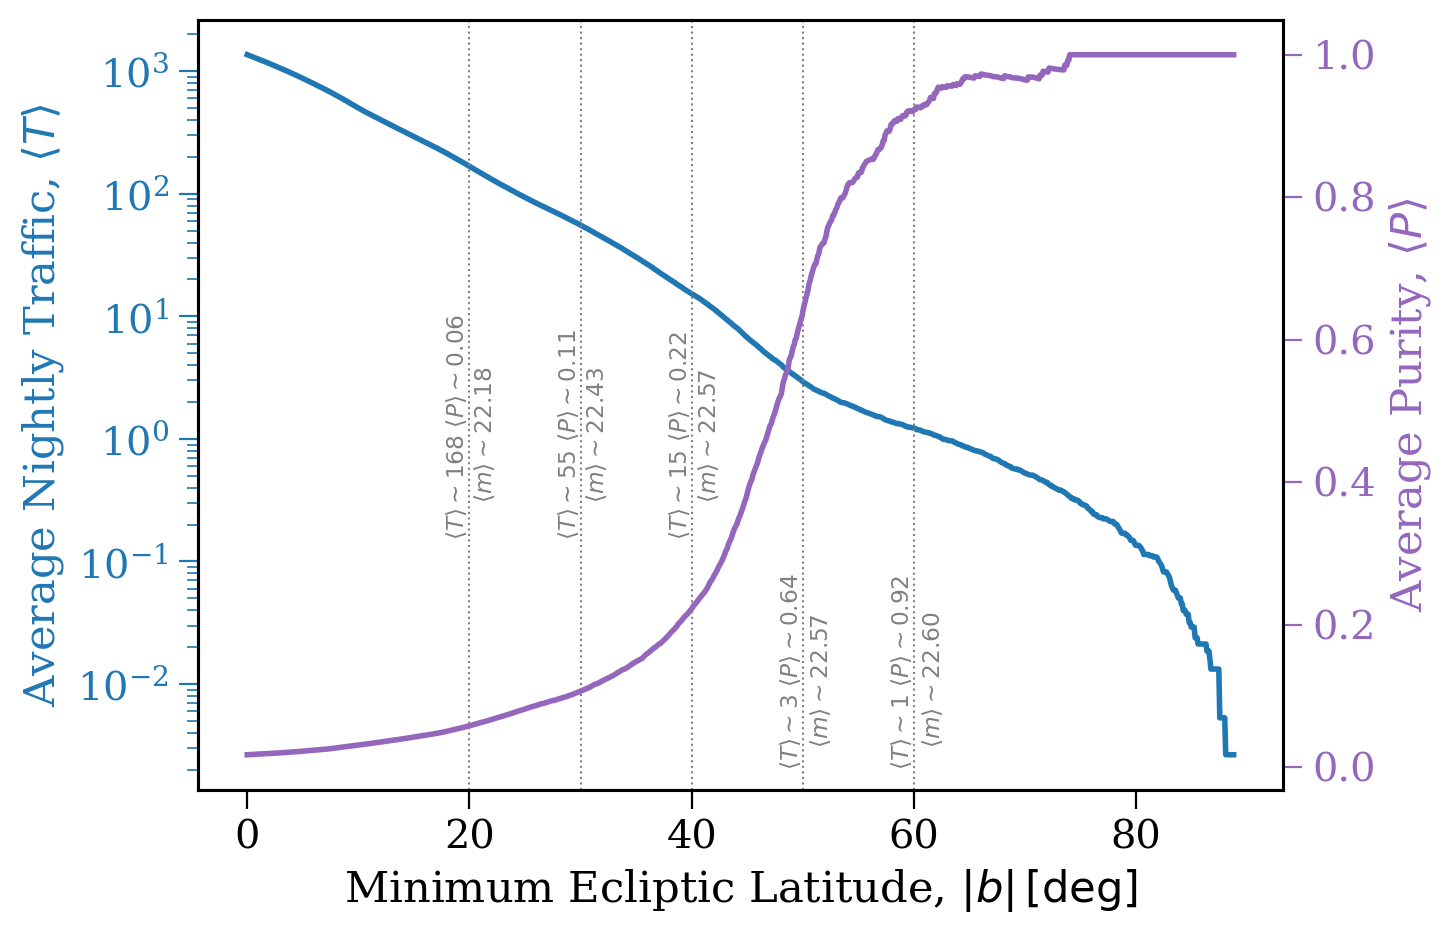

In [257]:
fig, ax = plt.subplots(figsize=(7, 5))

left_col = "tab:blue"
right_col = "tab:purple"

ax.plot(cutoffs, first_year_traffic / 377, lw=2)
ax.set_yscale("log")
ax.set_ylabel(r"Average Nightly Traffic, $\langle T \rangle$", fontsize=0.65*fs, color=left_col)

ax_right = ax.twinx()
ax_right.plot(cutoffs, first_year_purity, color=right_col, lw=2)
ax_right.set_ylabel(r"Average Purity, $\langle P \rangle$", fontsize=0.65*fs, color=right_col)
ax.set_xlabel(r"Minimum Ecliptic Latitude, $|b| \, {\rm [deg]}$", fontsize=0.65*fs)

ax.tick_params(axis="y", which="both", colors=left_col)
ax_right.tick_params(axis="y", which="both", colors=right_col)

for lim in range(20, 60 + 10, 10):
    t, p, am = first_year_stats(neo_obs_dd, mba_obs_dd, lim)
    ax.axvline(lim, color="grey", linestyle="dotted", lw=0.75)
    y_val = 2e-3 if lim >= 50 else 1.5e-1
    y_val2 = 3e-3 if lim >= 50 else 3e-1
    ax.annotate(rf"$\langle T \rangle{{\sim}}{{{t / 377:1.0f}}}$ $\langle P \rangle{{\sim}}{{{p:1.2f}}}$",
                xy=(lim, y_val), rotation=90, ha="right", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    ax.annotate(rf"$\langle m \rangle{{\sim}}{{{am:1.2f}}}$",
                xy=(lim * 1.01, y_val2), rotation=90, ha="left", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    
plt.savefig("../paper/figures/ecliptic_latitude_cutoff.pdf", format="pdf", bbox_inches="tight")
plt.show()

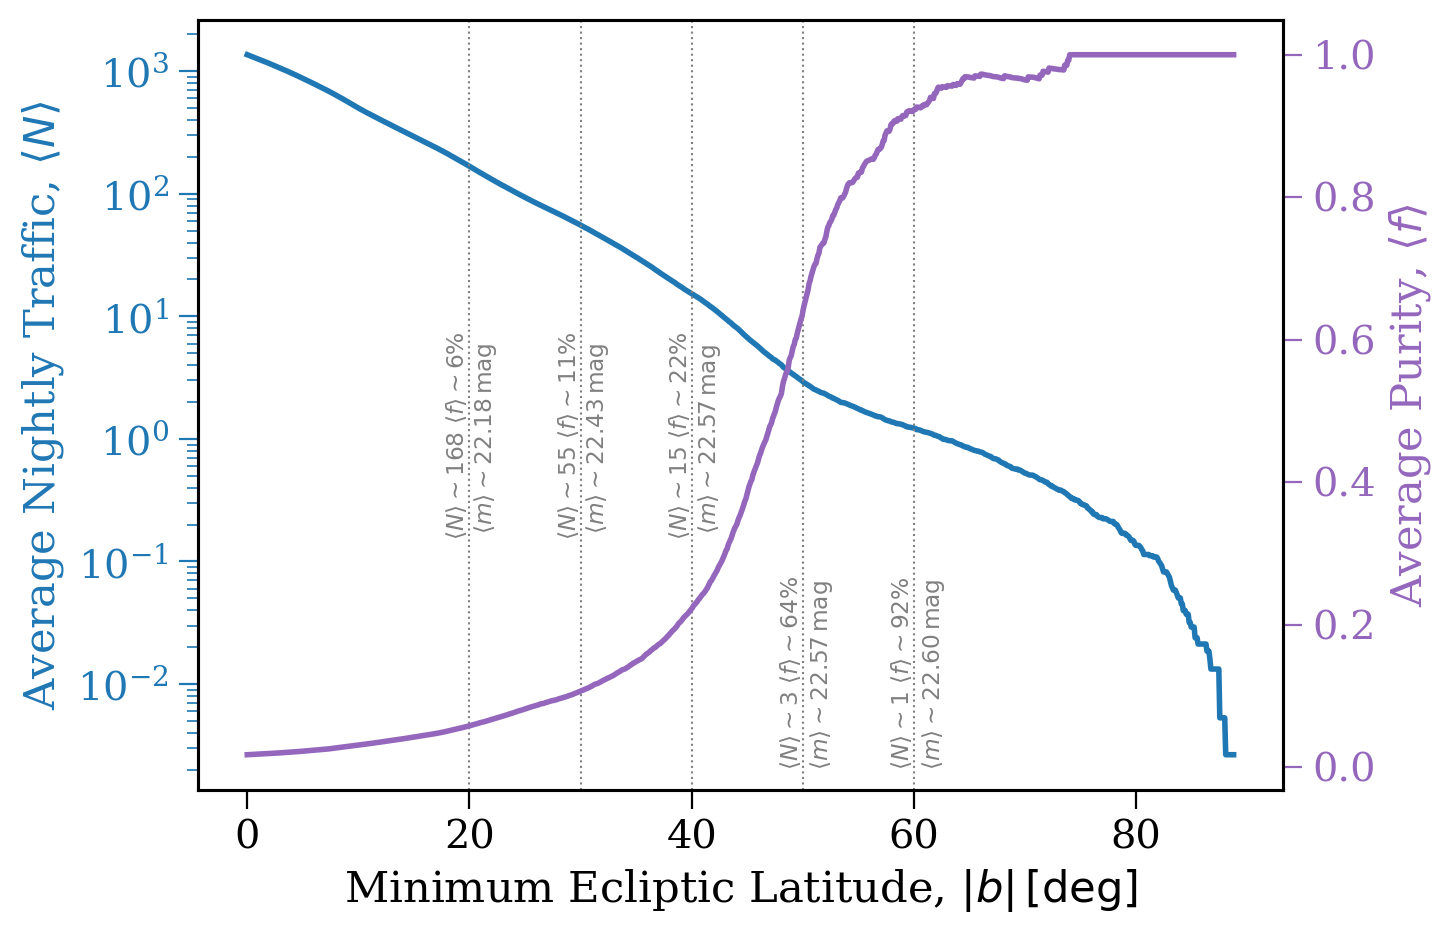

In [41]:
fig, ax = plt.subplots(figsize=(7, 5))

left_col = "tab:blue"
right_col = "tab:purple"

ax.plot(cutoffs, first_year_traffic / 377, lw=2)
ax.set_yscale("log")
ax.set_ylabel(r"Average Nightly Traffic, $\langle N \rangle$", fontsize=0.65*fs, color=left_col)

ax_right = ax.twinx()
ax_right.plot(cutoffs, first_year_purity, color=right_col, lw=2)
ax_right.set_ylabel(r"Average Purity, $\langle f \rangle$", fontsize=0.65*fs, color=right_col)
ax.set_xlabel(r"Minimum Ecliptic Latitude, $|b| \, {\rm [deg]}$", fontsize=0.65*fs)

ax.tick_params(axis="y", which="both", colors=left_col)
ax_right.tick_params(axis="y", which="both", colors=right_col)

for lim in range(20, 60 + 10, 10):
    t, p, am = first_year_stats(neo_obs_dd, mba_obs_dd, lim)
    ax.axvline(lim, color="grey", linestyle="dotted", lw=0.75)
    y_val = 2e-3 if lim >= 50 else 1.5e-1
    y_val2 = 2e-3 if lim >= 50 else 1.7e-1
    ax.annotate(rf"$\langle N \rangle{{\sim}}{{{t / 377:1.0f}}}$ $\langle f \rangle{{\sim}}{{{p * 100:1.0f}\%}}$",
                xy=(lim, y_val), rotation=90, ha="right", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    ax.annotate(rf"$\langle m \rangle{{\sim}}{{{am:1.2f}}} {{\rm \, mag}}$",
                xy=(lim * 1.01, y_val2), rotation=90, ha="left", va="bottom", fontsize=0.35*fs, color="grey", zorder=100)
    
plt.savefig("../paper/figures/ecliptic_latitude_cutoff.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [260]:
run_these = ""
for i in range(1, 10):
    base = i * 365
    for j in range(50):
        run_these += f"{base + j},"
run_these[:-1]

'365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,1095,1096,1097,1098,1099,1100,1101,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469,1470,1471,1472,1473,1474,1475,1476,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837,1838,1839,1840,1841,1842,1843,1844

In [93]:
neo_obs_dd

,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores,ecl_lat
hex_id,,,,,,,,,,,,
00000CC,S000003oa,0,59639.050099,103.270354,-58.417879,g,23.015736,23.642197,0.046104,5,100.0,-79.851805
0000243,S000009Ea,0,59639.304801,176.652133,-42.573063,r,20.777489,10.518543,0.009212,3,100.0,-39.628748
000022D,S000009ha,0,59639.040008,114.918387,-54.273962,g,22.414014,15.247105,0.026703,6,100.0,-72.837728
000095E,S00000DIa,0,59639.125760,108.665746,-35.512862,r,18.575234,10.051123,0.002581,4,100.0,-57.109121
00009E5,S00000FXa,0,59639.040456,120.050007,-57.737406,g,20.005139,10.203356,0.004691,4,100.0,-73.663444
...,...,...,...,...,...,...,...,...,...,...,...,...
003B50B,S00012Yua,377,60016.196926,184.369252,-6.129055,r,23.076850,39.945197,0.106033,4,100.0,-3.889187
003DCF7,S00015HIa,377,60016.197826,183.953196,-9.683373,r,23.584380,55.651727,0.147770,3,98.0,-7.313072
003E141,S00015ZTa,377,60016.122061,169.933871,-31.376348,r,22.855529,32.298346,0.078913,4,100.0,-32.483184


# Investigate outliers

In [41]:
import sys
sys.path.append("../neocp")
from lsst_neocp import find_first_file, find_last_file
from collections import defaultdict

night_start = 10
detection_window = 15
min_nights = 3
schedule_type="actual"

obj_type= "neo"
path = f"/epyc/projects/hybrid-sso-catalogs/neocp/{obj_type}/"

# create a list of nights in the detection window and get schedule for them
night_list = list(range(night_start, night_start + detection_window))

if schedule_type == "predicted":
    full_schedule = scheduling.get_LSST_schedule(night=night_start, schedule_type=schedule_type)
else:
    full_schedule = scheduling.get_LSST_schedule(night=(night_start, night_start + detection_window - 1),
                                      schedule_type=schedule_type)

# offset the schedule by one row and re-merge to get the previous night column
shifted = full_schedule.shift()
full_schedule["previousNight"] = shifted["night"]

# calculate the length of each night in days
night_lengths = np.zeros(detection_window)
for i, night in enumerate(night_list):
    mask = full_schedule["night"] == night

    # ignore nights that have no observations (bad weather/downtime)
    if not full_schedule[mask].empty:
        night_lengths[i] = full_schedule[mask].iloc[-1]["observationStartMJD"]\
            - full_schedule[mask].iloc[0]["observationStartMJD"]

# get the first/last visit from each night
night_transition = full_schedule["night"] != full_schedule["previousNight"]
first_visit_times = full_schedule[night_transition]["observationStartMJD"].values

last_times_ind = np.array(list(full_schedule[night_transition].index[1:]) + [len(full_schedule)]) - 1
last_visit_times = full_schedule.loc[last_times_ind]["observationStartMJD"].values

print("Schedule is loaded in and ready!")

# work out which visit files contain the observations
start_file = find_first_file(list(range(night_start - detection_window + 1, night_start)))
end_file = find_last_file(night_list)

# either open one file or concatenate a bunch of them
if start_file == end_file or start_file is None:
    all_obs = pd.read_hdf(path + f"filtered_visit_scores_{end_file:03d}.h5").sort_values("FieldMJD")
else:
    obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
                for i in range(start_file, end_file + 1)]
    all_obs = pd.concat(obs_dfs)

print("Observation files read in")

# get the sorted observations for the start night (that have digest2 > 65 and at least 3 observations)
sorted_obs = all_obs[(all_obs["night"] == night_start)
                     & (all_obs["scores"] >= 65)
                     & (all_obs["n_obs"] >= 3)].sort_values(["ObjID", "FieldMJD"])
unique_objs = sorted_obs.index.unique()

# get the prior observations that occurred in the past detection window that could possibly contribute
all_obs = all_obs[(all_obs["night"] > night_start - detection_window) & (all_obs["night"] < night_start)]
prior_obs = all_obs[all_obs.index.isin(unique_objs)]

print("Masks applied to observation files")

# create a (default)dict of the nights on which observations occurred
if prior_obs.empty:
    prior_obs_nights = defaultdict(list)
else:
    dd = defaultdict(list)
    s = prior_obs.groupby("hex_id").apply(lambda x: list(x["night"].unique()))
    prior_obs_nights = s.to_dict(into=dd)

    # identify objects that would not already have been detected before this night
    already_found_ids = s[s.apply(len) >= min_nights].index

    # reduce the original observations to include only these
    sorted_obs = sorted_obs[~sorted_obs.index.isin(already_found_ids)].sort_values(["ObjID", "FieldMJD"])
    unique_objs = sorted_obs.index.unique()

print("Everything is prepped and ready for probability calculations - Time to create some offspring")

Schedule is loaded in and ready!
Observation files read in
Masks applied to observation files
Everything is prepped and ready for probability calculations - Time to create some offspring


In [19]:
s3m_cart = pd.read_hdf("../catalogues/s3m_cart.h5")
s3m_cart["hex_id"] = np.array(['{:07X}'.format(num) for num in np.arange(len(s3m_cart.index.values))])

In [57]:
hex_id = "001218B"

In [10]:
from importlib import reload
reload(scheduling)
reload(variant_orbits)
reload(detection_probability)
reload(magnitudes)

<module 'magnitudes' from '/data/epyc/projects/hybrid-sso-catalogs/lsst_detection_probability/magnitudes.py'>

In [58]:
%%time
prob, joined_table = detection_probability.probability_from_id(hex_id, sorted_obs,
                                                 np.logspace(-1, 1, 5) * u.AU,
                                                 np.linspace(-50, 10, 3) * u.km / u.s, prior_obs_nights,
                                                 first_visit_times, full_schedule,
                                                 night_lengths, night_list, ret_joined_table=True)

CPU times: user 2.42 s, sys: 110 ms, total: 2.53 s
Wall time: 2.55 s


In [59]:
%%time
reachable_schedule = detection_probability.get_reachable_schedule(sorted_obs.loc[hex_id], first_visit_times,
                                                                  night_list, night_lengths, full_schedule)

CPU times: user 138 ms, sys: 3.2 ms, total: 141 ms
Wall time: 137 ms


In [60]:
%%time
ephemerides, truth = detection_probability.first_last_pos_from_id(hex_id, sorted_obs, s3m_cart,
                                                             np.logspace(-1, 1, 5) * u.AU,
                                                             np.linspace(-50, 10, 3) * u.km / u.s,
                                                             first_visit_times, last_visit_times)

CPU times: user 1.45 s, sys: 15.4 s, total: 16.9 s
Wall time: 17.9 s


In [56]:
sorted_obs[sorted_obs["AstDec(deg)"] >-10]

,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores
hex_id,,,,,,,,,,,
0000497,S00000jsa,10,59649.268419,153.800237,-7.104054,r,21.860776,16.737559,0.031112,4,100.0
0000497,S00000jsa,10,59649.269312,153.799869,-7.103956,r,22.018791,17.719626,0.032874,4,100.0
0000497,S00000jsa,10,59649.292944,153.790168,-7.101536,i,21.717671,24.228356,0.046000,4,100.0
0000497,S00000jsa,10,59649.293837,153.789817,-7.101473,i,21.732572,26.682993,0.049529,4,100.0
0001C4F,S00001Wca,10,59649.219075,154.372911,-9.952145,i,22.592378,27.896340,0.065659,4,100.0
0001C4F,S00001Wca,10,59649.220432,154.372196,-9.952234,i,22.585878,23.191492,0.058833,4,100.0
0001C4F,S00001Wca,10,59649.243554,154.359990,-9.953359,r,22.766582,30.568309,0.062513,4,100.0
0001C4F,S00001Wca,10,59649.244911,154.359281,-9.953417,r,22.789125,27.925161,0.059331,4,100.0
0001CE3,S00001YKa,10,59649.221780,160.083962,-5.305617,i,22.209833,18.681276,0.044548,3,100.0


In [61]:
reload(detection_probability)
interact(detection_probability.plot_LSST_schedule_with_orbits,
         schedule=fixed(full_schedule), reachable_schedule=fixed(reachable_schedule),
         ephemerides=fixed(ephemerides), truth=fixed(truth), joined_table=fixed(joined_table),
         night=widgets.IntSlider(min=night_start, max=night_start + detection_window - 1, step=1, value=night_start + 1, continuous_update=False),
         hex_id=fixed(hex_id),
         colour_by=widgets.Dropdown(
            value='distance',
            options=['distance', 'orbit'],
            description='Colour by:',
            ensure_option=True,
            disabled=False),
         lims=widgets.Dropdown(
            value='full_schedule',
            options=['orbits', 'full_schedule', 'schedule', 'reachable'],
            description='Axes limits:',
            ensure_option=True,
            disabled=False),
         filter_mask=widgets.Dropdown(
            value='all',
            options=['all', 'u', 'g', 'r', 'i', 'z', 'y'],
            description='Filter:',
            ensure_option=True,
            disabled=False),
         field_radius=fixed(2.1),
         s=widgets.IntSlider(min=1, max=25, step=1, value=15, continuous_update=False),
         show_mag_labels=widgets.ToggleButton(
            value=False,
            description='Show mag lims',
            disabled=False,
            button_style='success', # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Whether to show limiting magnitudes for each field',
            icon='check'),
         fig=fixed(None), ax=fixed(None),show=fixed(True), cbar=fixed(True), ax_labels=fixed(True)
        )

interactive(children=(IntSlider(value=11, continuous_update=False, description='night', max=24, min=10), Dropd…

<function detection_probability.plot_LSST_schedule_with_orbits(schedule, reachable_schedule, ephemerides, joined_table, truth, night, hex_id, colour_by='distance', lims='full_schedule', field_radius=2.1, s=10, filter_mask='all', show_mag_labels=False, fig=None, ax=None, show=True, ax_labels=True, cbar=True)>

# Are particular orbits harder to predict (I guess yes)

Update: I guessed wrong

In [93]:
true_params = s3m_cart[np.isin(s3m_cart["hex_id"], unique_objs)]

In [94]:
orbits_class = thor.Orbits(orbits=np.atleast_2d(np.concatenate(([true_params["x"], true_params["y"], true_params["z"]],
                                                                [true_params["vx"], true_params["vy"], true_params["vz"]]))).T,
                           epochs=Time(true_params["t_0"], format="mjd"))

In [95]:
orbits_class.keplerian

array([[1.63591956e+00, 4.24185921e-01, 4.57895783e+01, 3.43777755e+02,
        6.49956977e+01, 1.54872825e+02],
       [2.01117210e+00, 6.40305581e-01, 5.27938423e+01, 3.54874150e+02,
        2.33728656e+01, 2.21513638e+02],
       [1.46604986e+00, 5.28881346e-01, 2.65098657e+01, 2.50039142e+02,
        1.11672186e+02, 1.78288579e+02],
       ...,
       [1.60510044e+00, 2.95866783e-01, 2.45988084e+01, 1.92490199e+02,
        9.37351683e-01, 3.56766083e+02],
       [1.98769282e+00, 7.00609554e-01, 2.62840510e+01, 3.43548340e+02,
        8.28409374e+01, 3.58931646e+02],
       [1.96717633e+00, 7.80163838e-01, 1.65028245e+01, 1.76927663e+02,
        1.08970240e+02, 2.87917001e+02]])

In [96]:
q = orbits_class.keplerian[:, 0] * (1 - orbits_class.keplerian[:, 1])

In [97]:
got_it_right = (probs > 0.5) == will_be_detected

NameError: name 'probs' is not defined

In [291]:
colours = ["tab:green" if yup else "tab:red" for yup in got_it_right]

In [292]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


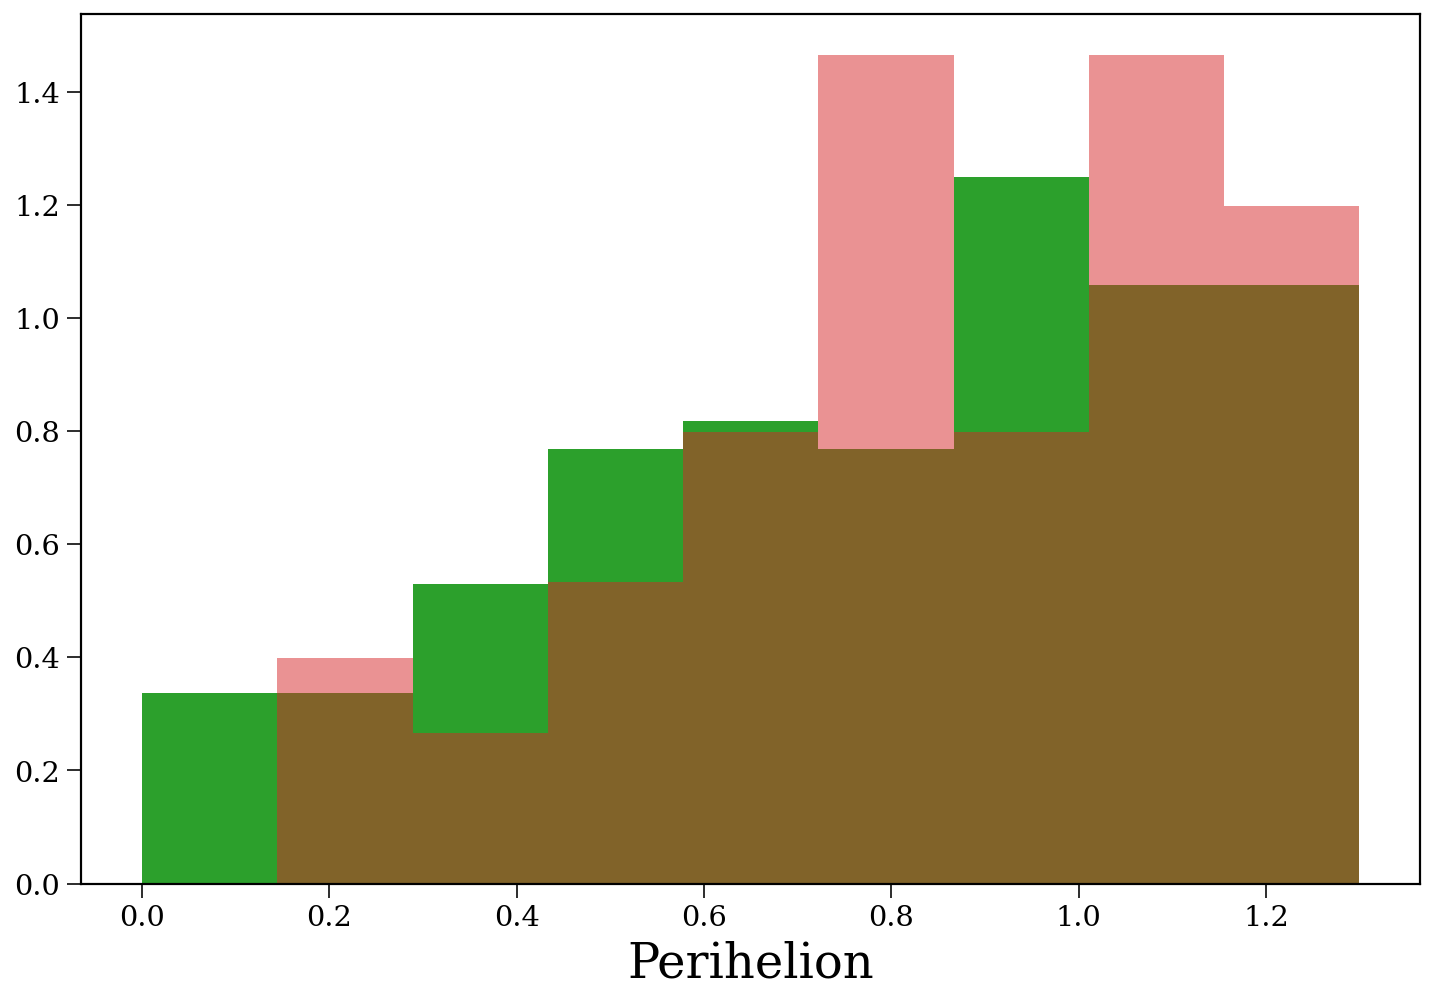

In [294]:
plt.hist(q[got_it_right], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False, color="tab:green")
plt.hist(q[np.logical_not(got_it_right)], bins=np.linspace(0, 1.3, 10), density=True, cumulative=False, alpha=0.5, color="tab:red")
plt.xlabel("Perihelion")
plt.show()

In [78]:
sc = SkyCoord(x=true_params["x"] * u.AU, y=true_params["y"] * u.AU, z=true_params["z"] * u.AU,
         v_x=true_params["vx"] * u.AU / u.day, v_y=true_params["vy"] * u.AU / u.day, v_z=true_params["vz"] * u.AU / u.day,
         frame="heliocentriceclipticiau76", representation_type="cartesian")

In [80]:
sc.transform_to("icrs").dec

<Latitude [-4.26195977e+01, -3.22914713e+01, -2.37231747e+01,
            1.59378369e+01, -4.09777900e+01,  3.78583545e+01,
           -1.06836469e+01, -2.98440073e+01,  5.16319752e-01,
           -3.87691675e+01, -3.50857780e+00,  3.82140340e+00,
           -5.20693997e+00, -3.95406799e+01,  4.33931175e+01,
           -9.75720779e+00, -5.21721060e+01, -5.89266611e+01,
           -2.24026068e+01, -4.80962996e+01, -2.81064499e+01,
            2.93205129e+01,  2.22192286e+01,  2.45959909e+00,
           -1.39388002e+01,  3.78021236e+01, -7.45805364e+00,
           -1.11743370e+00, -4.19530486e+01, -4.92075884e+01,
           -5.41168944e+01,  3.54369955e+00, -1.97183381e+01,
            2.78456311e+01, -2.73656530e+01,  1.96673108e+01,
            2.10235692e+01,  1.14507319e+01, -3.18970816e+01,
           -1.33822790e+01,  2.04241291e+01, -2.48786846e+01,
           -4.52631713e+00,  3.23004632e+01, -2.09499206e+01,
           -2.33388521e+01,  1.84905706e+01,  1.88503133e+01,
        

In [300]:
np.median(true_params["H"][got_it_right])

22.271

In [298]:
np.median(true_params["H"][~got_it_right])

22.8455

In [301]:
true_params

,id,x,y,z,vx,vy,vz,coords,t_0,time_type,H,g,hex_id
S000002Ma,167.0,-1.667047,-0.858776,-1.326359,0.004811,-0.005856,-0.004398,1.0,54466.0,3.0,15.849,0.15,00000A7
S000005Aa,335.0,-2.670562,-0.879820,-1.468497,0.004954,-0.002611,-0.002842,1.0,54466.0,3.0,16.713,0.15,000014F
S000009Ea,579.0,-2.034149,-0.117710,-0.933631,-0.000217,-0.007789,0.001225,1.0,54466.0,3.0,17.390,0.15,0000243
S00000fua,932.0,-0.816946,3.114705,-0.379257,-0.006347,0.001696,-0.000940,1.0,54466.0,3.0,17.977,0.15,00003A4
S00000jsa,1175.0,-1.428541,-0.739073,-1.059737,0.010892,-0.002073,0.003008,1.0,54466.0,3.0,18.259,0.15,0000497
...,...,...,...,...,...,...,...,...,...,...,...,...,...
S00015ySa,252642.0,-1.241447,0.363831,-0.070625,-0.000347,-0.015706,-0.002807,1.0,54466.0,3.0,24.924,0.15,003DAE2
S00015RKa,253781.0,2.664565,-1.647325,0.364562,0.003198,0.006329,-0.000184,1.0,54466.0,3.0,24.930,0.15,003DF55
S00017xaa,260048.0,-1.120751,-0.151135,-0.043414,0.002398,-0.016566,0.007642,1.0,54466.0,3.0,24.960,0.15,003F7D0
S0001805a,261795.0,0.300718,0.449375,0.254915,-0.025643,0.013277,0.002702,1.0,54466.0,3.0,24.968,0.15,003FEA3


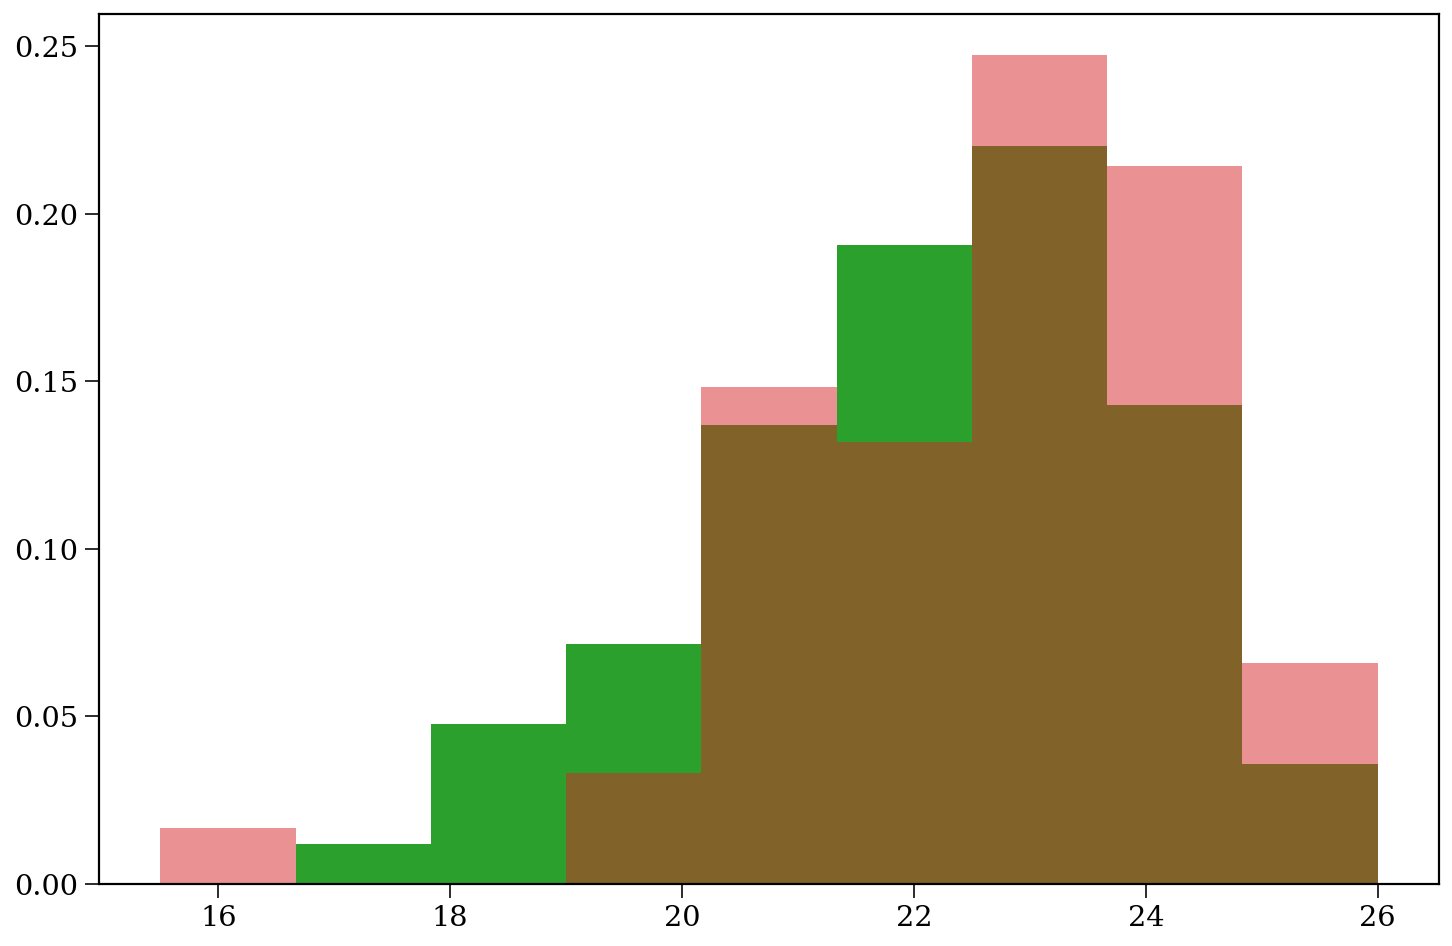

In [295]:
plt.hist(true_params["H"][got_it_right], density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:green")
plt.hist(true_params["H"][np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=False, bins=np.linspace(15.5, 26, 10), color="tab:red")
plt.show()

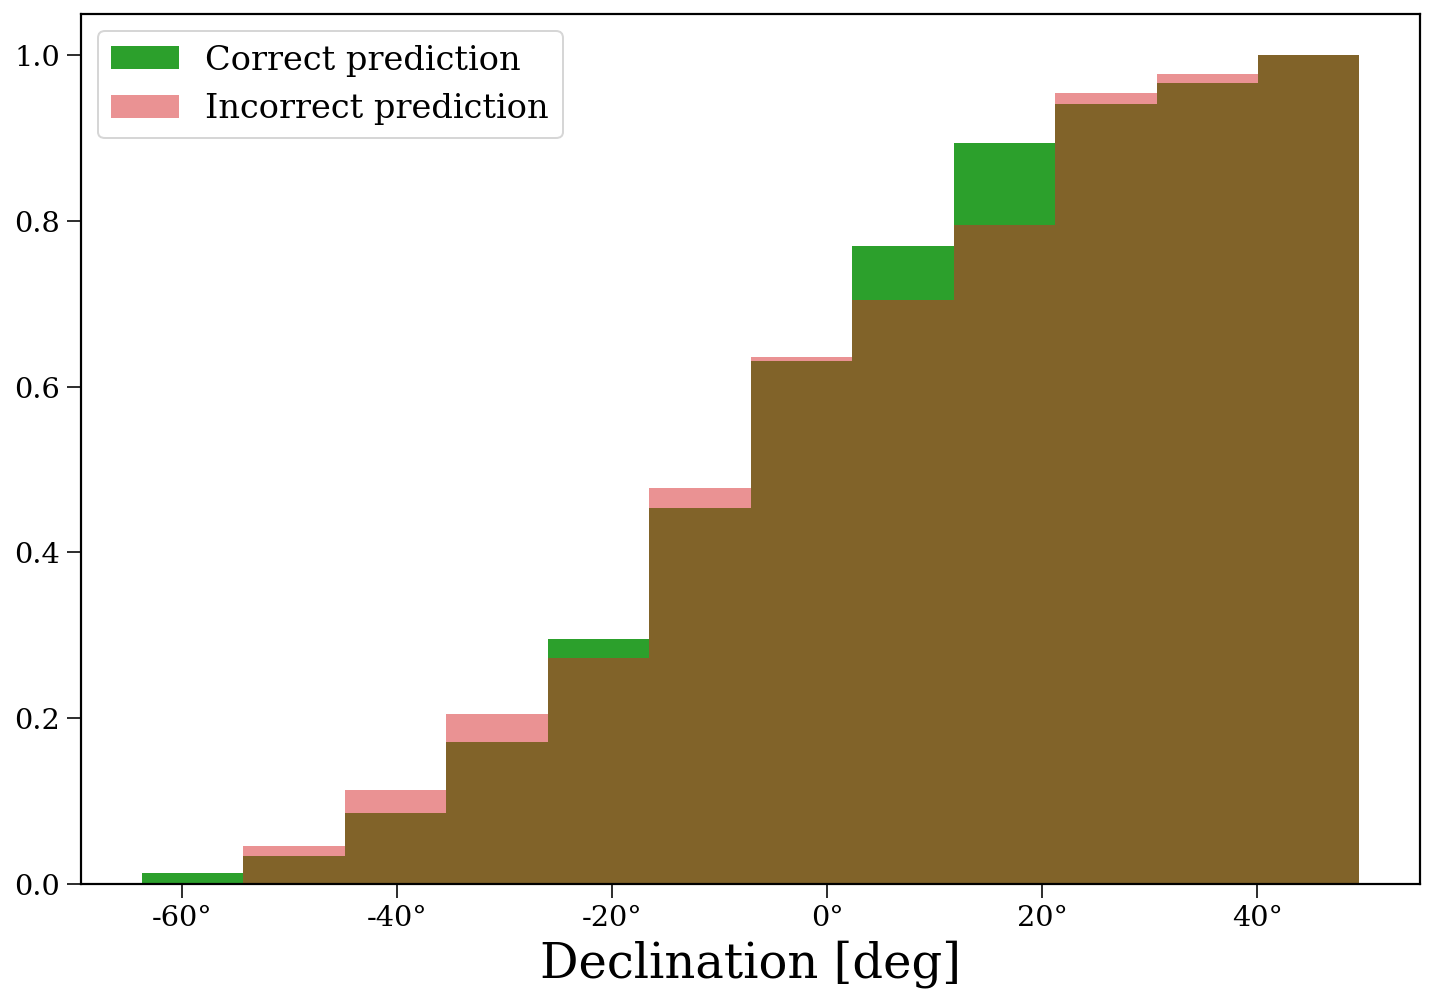

In [89]:
bins = np.linspace(min(sc.transform_to("icrs").dec), max(sc.transform_to("icrs").dec), 13)

plt.hist(sc.transform_to("icrs").dec[got_it_right], density=True, cumulative=True, bins=bins, color="tab:green", label="Correct prediction")
plt.hist(sc.transform_to("icrs").dec[np.logical_not(got_it_right)], alpha=0.5, density=True, cumulative=True, bins=bins, color="tab:red", label="Incorrect prediction")

plt.legend(fontsize=0.7*fs)

plt.xlabel("Declination [deg]")

plt.show()

# Probability of each predicted detection based on orbit fraction

In [229]:
for i in range(10, 25):
    x = joined_table[joined_table["observed"] & (joined_table["night"] == i)]
    print(i)
    print(x.groupby("mjd_utc").count()["orbit_id"] / len(joined_table["orbit_id"].unique()) * 100)
    print()

10
mjd_utc
59649.295709    100.0
59649.296156    100.0
59649.320180    100.0
59649.320627    100.0
Name: orbit_id, dtype: float64

11
mjd_utc
59650.330174    100.000000
59650.351728     99.543379
Name: orbit_id, dtype: float64

12
mjd_utc
59651.250333    1.065449
59651.274791    0.913242
Name: orbit_id, dtype: float64

13
mjd_utc
59652.367719    77.625571
59652.376183     0.456621
59652.377078     6.392694
59652.378861    36.834094
59652.387323     0.608828
59652.388219     6.392694
Name: orbit_id, dtype: float64

14
mjd_utc
59653.244888    1.065449
59653.247818    3.500761
59653.268607    1.065449
59653.271480    3.348554
Name: orbit_id, dtype: float64

15
mjd_utc
59654.240757    8.980213
59654.241222    3.500761
59654.241678    0.608828
59654.242138    1.369863
59654.264676    9.132420
59654.265141    3.500761
59654.265598    0.608828
59654.266058    1.522070
Name: orbit_id, dtype: float64

16
mjd_utc
59655.262812     1.674277
59655.263260     2.435312
59655.263715    26.940639
59655

In [205]:
x = joined_table[joined_table["observed"] & (joined_table["night"] == 18)]
x.groupby("mjd_utc").count()["orbit_id"].values / len(joined_table["orbit_id"].unique()) * 100

array([ 0.15384615,  0.76923077, 36.        , 26.30769231,  8.30769231,
       19.38461538, 10.15384615,  2.61538462,  0.15384615,  0.76923077,
       36.30769231, 26.30769231,  8.30769231, 19.53846154, 10.30769231,
        2.46153846,  0.15384615,  0.76923077, 36.        , 26.30769231,
        8.        , 19.53846154, 10.46153846,  2.46153846,  0.15384615,
        0.76923077, 35.84615385, 26.30769231,  8.        , 19.38461538,
       10.76923077,  2.46153846,  0.76923077, 26.30769231,  8.        ,
       19.23076923, 35.84615385,  0.15384615,  0.76923077, 26.15384615,
        8.        , 19.38461538, 35.69230769,  0.15384615,  0.15384615,
        0.76923077, 35.69230769, 26.15384615,  0.15384615,  1.69230769,
       19.69230769, 10.61538462,  2.30769231,  0.15384615,  0.76923077,
       35.53846154, 26.15384615,  0.15384615,  1.84615385, 19.38461538,
       10.61538462,  2.30769231])

In [304]:
obs_dfs = [pd.read_hdf(path + f"filtered_visit_scores_{i:03d}.h5").sort_values("FieldMJD")
               for i in range(24)]
all_obs = pd.concat(obs_dfs)

time_mask = all_obs["night"] >= night_start
all_obs = all_obs[time_mask]

all_obs["obs_id"] = np.arange(len(all_obs))
all_obs.reset_index(inplace=True)

In [305]:
all_obs

,hex_id,ObjID,night,FieldMJD,AstRA(deg),AstDec(deg),filter,MaginFilter,AstrometricSigma(mas),PhotometricSigma(mag),n_obs,scores,obs_id
0,0002D81,S0000375a,10,59649.208350,158.519607,-21.678267,i,22.695297,28.561714,0.069045,2,99.0,0
1,000756F,S000082pa,10,59649.208350,159.243530,-22.482021,i,23.191904,49.406436,0.121825,2,100.0,1
2,000979F,S0000anGa,10,59649.208350,156.766833,-21.072815,i,20.379974,10.765338,0.010571,4,100.0,2
3,003321F,S0000U1aa,10,59649.208829,155.845105,-26.065509,i,22.082711,18.883869,0.041834,2,100.0,3
4,0007FE1,S00008Kza,10,59649.208829,157.776514,-24.367675,i,23.515696,61.119239,0.149723,2,100.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236035,00003A1,S00000fqa,377,60016.383717,219.053646,10.663359,y,21.051834,47.484220,0.099880,2,51.0,236035
236036,0000207,S000008Da,377,60016.383717,217.021350,11.143723,y,21.567851,62.038809,0.129902,2,69.0,236036
236037,000162E,S00001w5a,377,60016.385062,224.087428,5.934778,y,21.077982,55.793997,0.108452,6,86.0,236037
236038,000EF87,S0000gp7a,377,60016.385986,227.535324,6.440746,y,21.362047,51.847973,0.111037,2,95.0,236038
